# W261 Final Project "Click Through Rate Prediction on Criteo Advertising Data"
# Team: Ahsen, Divya, Lance, Ravi, Sameed

## Background

In 2014, Criteo Labs launched a Kaggle Competition that encouraged Kagglers to submit the most accurate ML algorithm for Click Through Rate Label Estimation.  

Criteo serves digital online display advertisements that helps companies and brands acquire, convert, and re-engage their customers online via display advertisements.  The company collects data from users and pools the data to additionally offer insights into customer purchasing habits and intent. It leverages machine learning on its proprietary data, serving digital advertisements across different channels. Criteo currently collects data on over 800b USD worth of e-commerce transactions and has delivered over 10b targeted clicks in 2018. Criteo offers their digital advertisement services on a cost-per-click basis along with follow-up data that ties to post-click sales, facilitating a click-to-purchase Cost-of-Acquisition Metric available to its customers.

As part of Kaggle competition, Criteo provided a training and test set of its internal proprietary data and 718 individual teams competed for the 16,000 USD prize amount.

### Imports

In [1]:
# imports
import os
import re
import sys
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.accumulators import AccumulatorParam
from pyspark.sql.types import *
from pyspark.ml.feature import FeatureHasher
from pyspark.sql.functions import udf, countDistinct, isnan, when, count, col, lit
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
from pyspark.sql.functions import isnull, coalesce, concat
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

from pyspark.mllib.evaluation import MulticlassMetrics
from math import exp, sqrt, log
from pyspark.sql.functions import countDistinct, count, isnan, col, when, lit

%matplotlib inline
sns.set(style="darkgrid")

## 1. Question Formulation

Our team is working with data released by Criteo to create a scalable machine learning algorithm to correctly predict ad click-through-rate (CTR). 

Year over year e-commerce has continued to grow, making up over 11% of all retail transactions within the US and accounting for over $500 billion dollars in sales in 2018 alone. In order to maintain a competitive edge in such a large market, advertisers have developed sophisticated and scalable targeted advertising methods to grow their customer base while ensuring ad expenditures are optimized. By targeting customers more effectively, advertisers are able to reduce the Cost of Acquisition (CAC) for a given individual, mitigating the amount of ad-spend that goes wasted. Consequently, advertisers have a strong interest in ensuring that ads are properly targeted and Click Through Rates (CTRs) are high. In cost per click (CPC) and cost per conversion (CPA) pricing models, ensuring CTRs are high is a particularly important challenge to address for publishing companies because it allows the company to maximize its profits when it pairs users with advertisements that the user is likely to click. Although the implications and promises of targeted advertising are alluring, it does not come without its challenges. In particular, targeted advertising needs to understand user-behaviour and/or have a user-history in order to be effective. 

It should be noted that even though a high CTR is important, it is just one factor in a chain of others that lead to a sale - other downstream conversion efforts are critical to closing a customer's sale.

The most robust ad models should include very specific customer segmentation demographics, psychographics, and past purchase and other user behavior. As part of the kaggle contest however, we are looking at a more limited data set, with the particular challenge of not knowing the representation and significance of our columns. This is particularly challenging because we can only guess as to what each of these fields represent, but we cannot use outside knowledge to help us develop our models. Consequently, we attempt to understand what types of data we are dealing with, what the shortcomings of our data are - whether it's incomplete, erroneous, or includes omissions and NaN values, and how to strategically implement feature engineering.

In an ideal world with perfect information, we would be able to serve up advertisements that have a 100% CTR; that is, each ad we serve ups results in a click. This would then enable us to focus on conversion tactics that follow the initial ad click. However, a CTR of over 2% for a search advertisement would be terrific. Typically, CTRs are divided up by industry and geolocation, as each industry's customer has a different profile. For display advertisements, which is what Criteo primarily sells, a CTR of above 0.4% would be very good.

For our model to be practically useful, we would need to develop a model for Criteo that beats the average CTR in the industry. This would lead to more advertising spend and revenue for Criteo as advertisers spend more on the platform to take advantage of the company being a better source of customer acquisition at a lower costs. For our model to be practically useful, we would want to see any improvement over our current models that is greater than that of random chance, that allows us to target users and get a CTR higher than our current benchmarks. Ideally, the more simpler the algorithm, the better.

The goal of our model will be to develop the most accurate model we can generate for predicting whether or not a user will click an advertisement. In doing so, we will be able to optimize which ads to pair with users to increase Criteo's CTR and subsequently its revenue by serving advertisements to high-propensity groups?


## 2. Algorithm Explanation

### Logistic Regression Explanation and Calculation by Hand

Since predicting a user click through rate is by nature a binary classification task, the primary model we use to answer the question is logistic regression, optimized using gradient descent. Logistic regression is a linear model that, instead of predicting values, predicts probabilities. This model is widely used and highly useful as a binary classifier, such as this problem.

There are some clear advantages to logistic regression:
- Logistic regression is very efficient and requires less computational resources than other models. 
- Logistic regression is easy to work with. This model doesn't require much tuning, and it is easy to implement scalable regularization. 
- Logistic regression outputs model results that are well-calibrated predicted probabilities and generally more interpretable than other algorithms. 
- Logistic regression identifies directionality (i.e. positive and negative relationships), while other models, such as decision trees and neural networks, do not.
- Logistic regression is often hard to beat in terms of accuracy. 

This model was built and implemented using RDDs in Pyspark. As a competitor (model performance and train time), we have also implemented ML's LogisticRegression package for DataFrames. 

#### Logistic Regression

We first define our log-odds equation with two parameters x1, and x2 as:

$l = \beta_0 + \beta_{1}x_1 + \beta_{2}x_2$

Where l = log-odds, $\beta 's$ represent coefficients and are the parameters of the model, and x represents a predictors in the model.

The odds can now be presented as follows: 

$odds = b^{\beta_0 + \beta_{1}x_1 + \beta_{2}x_2}$

Where b represents the base of the logarithm and exponent. Adding this non-linearity allows us to define the odds as a probability function as follows:

$$ y = \operatorname{Pr}(clicked) = \frac{e^{\beta_0 + \beta_{1}x_1 + \beta_{2}x_2}}{1 + e^{\beta_0 + \beta_{1}x_1 + \beta_{2}x_2}} $$

This function takes in the log-odds as an input, and outputs the probability between 0 and 1.

We look at the Logistic Regression in it's matrix form where:

$$ \boldsymbol{X}^T = \begin{bmatrix} x_{1}  \ ... \ x_{m}\ \end{bmatrix}$$

$$ \boldsymbol{Y}^T = \begin{bmatrix} y_{1}  \ ... \ y_{m}\ \end{bmatrix}$$

$$ \boldsymbol{x_i} = \begin{bmatrix} x_{i1}  \ ... \ x_{ij}\ \end{bmatrix}$$

$$\boldsymbol{\theta}^T = \begin{bmatrix} \beta_{0}  \ \beta_{1} ... \ \beta_{j} \end{bmatrix}$$

And let sigmoid function G(z) be:

$$ G(z) = \frac{1}{1 + e^{-z}}$$

where $z = (x_i \theta^T)$

We then get the prediction for the class as follows:

$$y_i = G(z)$$


#### Defining Loss Function

With any machine learning model, we need to define a loss that we seek to minimize. In logistic regression, we define the loss function (logloss) as follows: 

$$ p = \hat{y_i} = G(z) = G(x_i * \theta^T) $$

$$ J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \dot (y_i * log(p) - (1-y_i) log(1-p)) $$

Where y is the true label for the $i^{th}$ row of data.

Now, simply put, we can think of the loss function as the error in our predicted probability relative to the actual class, where a logloss of 0 would mean our model is predicting the class perfectly.

#### Gradient Descent

We aim to the optimize the $\beta$ coefficients such that logloss is minimized as we train our model. In order to do that, we can use the method of gradient descent where we iteratively adjust the coefficients $\theta$ to the direction that decreases the loss function. And that direction is given to us by the derivative of the loss function.  

Taking a derivative of the loss function with respect to  θ , we can get that the gradient as:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (G(x_i * \theta^T) - y_i) * x_{ij}$$

And with the gradient computed, in every iteration, we compute the updates to our weights, $\theta$, by:

$$ \theta_{new} = \theta - \alpha * \frac{\partial J(\theta)}{\partial \theta_j} $$

where $\alpha$ is the learning rate for the gradient descent.

### Create Spark Session

In [2]:
# start Spark Session
app_name = "Final_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

### Create Toy Dataset

In [136]:
# create a hashed version of the mini toy df
toyDfHash = spark.createDataFrame([
   (0, 0, 1),
   (1, 1, 1),
   (1, 1, 0),
   (0, 1, 1)
], ["label", "f1", "f2"])

hasher = FeatureHasher(inputCols=["f1", "f2"],
                       outputCol="features")

featurized = hasher.setCategoricalCols(["f1", "f2"]).transform(toyDfHash)
featurized.show(truncate=False)

+-----+---+---+---------------------------------+
|label|f1 |f2 |features                         |
+-----+---+---+---------------------------------+
|0    |0  |1  |(262144,[57095,87362],[1.0,1.0]) |
|1    |1  |1  |(262144,[57095,200607],[1.0,1.0])|
|1    |1  |0  |(262144,[35760,200607],[1.0,1.0])|
|0    |1  |1  |(262144,[57095,200607],[1.0,1.0])|
+-----+---+---+---------------------------------+



#### Logistic Regression Hand Calculation on Toy Dataset

In the toy example above, we run through a hand calculation to walk through the steps for computing logistici regression using gradient descent.

The parameter vector $\theta$ for the initial function $y=\frac{1}{1+e^{-x\theta^T}}$ is: 
$ \begin{bmatrix} 0 \ \quad 0 \ \quad 0 \ \end{bmatrix}$, where 0 is the value for the $\beta$ coefficient for x1, x2, and bias.

In this example, the first column for x represents x1, the second column represents x2, and the third column represents the bias term. 

**Our predicted value hand calculations are:**

|  $x_j '$  | $y_j$ |   $\frac{1}{1+e^{-x\theta^T}}$ | 
|:---------:|:-----:|:-------------------------------------:|
|  input   | true y   |   predicted y   |
| $ \begin{bmatrix} 0 \\ 1 \\ 1 \\ \end{bmatrix}$   |  0   | 0.5             |  
| $ \begin{bmatrix} 1 \\ 1 \\ 1 \\ \end{bmatrix}$   |  1   | 0.5             |  
| $ \begin{bmatrix} 1 \\ 0 \\ 1 \\ \end{bmatrix}$   |  1   | 0.5             | 
| $ \begin{bmatrix} 1 \\ 1 \\ 1 \\ \end{bmatrix}$   |  0   | 0.5             |

**Compute Logloss**

To compute the log-loss, we take the log of the logistic regression function.

Taking this log, using a scale from 0-1, we can derive the loss function as follows:

Let z represent the $\theta\cdot{x}'_j$ portion of the model above, and m represents each example, or data point. 

$Loss = -\frac{1}{m}\displaystyle \sum_{i=1}^{m} y_i(log(z)) - (1-y_i)log(1-z))$

This loss above is calculated for the entire model. To calculate the loss at each point, we use the following portion of the loss function: 

$Loss_i = -y_i(log(z)) - (1-y_i)log(1-z))$

**Our loss calculations for the first round is:**

|  $x_j '$  | $y_j$ |   $\frac{1}{1+e^{-\theta\cdot{x}'_j}}$ | $-y_i(log(z)) - (1-y_i)log(1-z))$ |
|:----:|:-----:|:----------------:|:--------------------------------:|
|  input   | true y   |   predicted y   |     loss for $x_j$          |
| $ \begin{bmatrix} 0 \\ 1 \\ 1 \\\end{bmatrix}$   |  0  |        0.5         |        0.69          |
| $ \begin{bmatrix} 1 \\ 1 \\ 1 \\\end{bmatrix}$   |  1  |        0.5         |        0.69          |
| $ \begin{bmatrix} 1 \\ 0 \\ 1 \\\end{bmatrix}$   |  1  |        0.5         |        0.69          |
| $ \begin{bmatrix} 1 \\ 1 \\ 1 \\\end{bmatrix}$   |  0  |        0.5         |        0.69          |

The logloss for this round would then be $\frac{0.69 + 0.69 + 0.69 + 0.69}{4} = 0.69$

**Gradient Descent**

Next, we conduct gradient descent to get the updated weights that need to go into our model for the next iteration. To do so, we calculate the gradient for each prediction, and update the weights accordingly using the following formula:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (H(x_i) - y_i) * x_{ij}$$

The resulting gradient update for each coefficient goes as follows:

|  $x_j '$  | $y_j$ |   $\frac{1}{1+e^{-\theta\cdot{x}'_j}}$ | $(H(x_i) - y_i) * x_{ij}$ |
|:----:|:-----:|:----------------:|:--------------------------------:|
|  input   | true y   |   predicted y   |     gradient          |
| $ \begin{bmatrix} 0 \\ 1 \\ 1 \\\end{bmatrix}$   |  0  |        0.5         |$ \begin{bmatrix} 0 \\ 0.5 \\ 0.5 \\\end{bmatrix}$|
| $ \begin{bmatrix} 1 \\ 1 \\ 1 \\\end{bmatrix}$   |  1  |        0.5         |$ \begin{bmatrix} -0.5 \\ -0.5 \\ -0.5 \\\end{bmatrix}$|
| $ \begin{bmatrix} 1 \\ 0 \\ 1 \\\end{bmatrix}$   |  1  |        0.5         |$ \begin{bmatrix} -0.5 \\ 0 \\ -0.5 \\\end{bmatrix}$|
| $ \begin{bmatrix} 1 \\ 1 \\ 1 \\\end{bmatrix}$   |  0  |        0.5         |$ \begin{bmatrix} 0.5 \\ 0.5 \\ 0.5 \\\end{bmatrix}$|

The gradient for each row of data would be accumulated to generate the following update:

$$ \theta_{new} = \theta - \alpha * \frac{\partial J(\theta)}{\partial \theta_j} $$

where across all rows of training data = $\frac{\partial J(\theta)}{\partial \theta_j}$ = $\frac{\begin{bmatrix} −0.5 \ \quad 0.5 \ \quad 0 \ \end{bmatrix}}{4}$ = $\begin{bmatrix} −0.25 \ \quad 0.25 \ \quad 0 \ \end{bmatrix}$

To get $\theta_{new}$, we need to multiply $\frac{\partial J(\theta)}{\partial \theta_j}$ by $\alpha$ (the learning rate for our gradient descent algorithm), and subtract this from the current model. For the purpose of this exercise, $\alpha = 0.1$ so the formula would look like the following.

$ \theta_{new} = \begin{bmatrix} 0.0 \ \quad 0.0 \ \quad 0.0 \ \end{bmatrix} - 0.1 * \begin{bmatrix} −0.25 \ \quad 0.25 \ \quad 0 \ \end{bmatrix}$

Our new model weights would now become:

$ \theta_{new} = \begin{bmatrix} 0.025 \ \quad -0.025 \ \quad 0.0 \ \end{bmatrix}$


## 3. Exploratory Data Analysis

### Data Overview and Description

The data provided consists of the following:

- label - Target variable that indicates if an ad was clicked (1) or not (0)
- i1-i13 - A total of 13 columns of integer features (mostly count features).
- c1-c26 - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits to anonymize the data. 

Notes
- The semantics of the features is undisclosed. This means that we cannot do feature selection based on the qualitative content of the features
- When a value is missing, the field is empty.

Based on the above, one of our main limitations is not knowing what the provided features are. 

### Obtain the dataset

The data for this project was retrieved from: https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

In [4]:
!wget -c https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz -O - | tar -xz -C ./data/

--2019-04-16 03:53:39--  https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.53.106
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.53.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4576820670 (4.3G) [application/x-gzip]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: data: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
-                     0%[                    ] 101.60K   357KB/s    in 0.3s    


Cannot write to ‘-’ (Broken pipe).


In [4]:
#bucket = "w261-gcp/notebooks"
bucket = "lance_miles_w261"

trainTxtPath = "gs://{}/data/train.txt".format(bucket)
testTxtPath = "gs://{}/data/test.txt".format(bucket)    

In [5]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('data/test.txt')
trainRDD = sc.textFile('data/train.txt')

In [6]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile(trainTxtPath)
trainRDD = sc.textFile(testTxtPath)

First, we will define the schema for the training and test dataset. Providing the schema instead of asking Spark to infer the schema will speed up the dataframe creation process as it will save the time taken to inspect all the records to identify the correct schema. Further, the test data does not have the output column - label so the schema would be different.

In [7]:
traincsvSchema = StructType([StructField("label", IntegerType(), False), StructField("i1", IntegerType(), False),
                            StructField("i2", IntegerType(), False), StructField("i3", IntegerType(), False),
                            StructField("i4", IntegerType(), False), StructField("i5", IntegerType(), False),
                            StructField("i6", IntegerType(), False), StructField("i7", IntegerType(), False),
                            StructField("i8", IntegerType(), False), StructField("i9", IntegerType(), False),
                            StructField("i10", IntegerType(), False), StructField("i11", IntegerType(), False),
                            StructField("i12", IntegerType(), False), StructField("i13", IntegerType(), False),
                            StructField("c14", StringType(), False), StructField("c15", StringType(), False),
                            StructField("c16", StringType(), False), StructField("c17", StringType(), False),
                            StructField("c18", StringType(), False), StructField("c19", StringType(), False),
                            StructField("c20", StringType(), False), StructField("c21", StringType(), False),
                            StructField("c22", StringType(), False), StructField("c23", StringType(), False),
                            StructField("c24", StringType(), False), StructField("c25", StringType(), False),
                            StructField("c26", StringType(), False), StructField("c27", StringType(), False),
                            StructField("c28", StringType(), False), StructField("c29", StringType(), False),
                            StructField("c30", StringType(), False), StructField("c31", StringType(), False),
                            StructField("c32", StringType(), False), StructField("c33", StringType(), False),
                            StructField("c34", StringType(), False), StructField("c35", StringType(), False),
                            StructField("c36", StringType(), False), StructField("c37", StringType(), False),
                            StructField("c38", StringType(), False), StructField("c39", StringType(), False)])

In [8]:
testcsvSchema = StructType([StructField("i1", IntegerType(), False),
                            StructField("i2", IntegerType(), False), StructField("i3", IntegerType(), False),
                            StructField("i4", IntegerType(), False), StructField("i5", IntegerType(), False),
                            StructField("i6", IntegerType(), False), StructField("i7", IntegerType(), False),
                            StructField("i8", IntegerType(), False), StructField("i9", IntegerType(), False),
                            StructField("i10", IntegerType(), False), StructField("i11", IntegerType(), False),
                            StructField("i12", IntegerType(), False), StructField("i13", IntegerType(), False),
                            StructField("c14", StringType(), False), StructField("c15", StringType(), False),
                            StructField("c16", StringType(), False), StructField("c17", StringType(), False),
                            StructField("c18", StringType(), False), StructField("c19", StringType(), False),
                            StructField("c20", StringType(), False), StructField("c21", StringType(), False),
                            StructField("c22", StringType(), False), StructField("c23", StringType(), False),
                            StructField("c24", StringType(), False), StructField("c25", StringType(), False),
                            StructField("c26", StringType(), False), StructField("c27", StringType(), False),
                            StructField("c28", StringType(), False), StructField("c29", StringType(), False),
                            StructField("c30", StringType(), False), StructField("c31", StringType(), False),
                            StructField("c32", StringType(), False), StructField("c33", StringType(), False),
                            StructField("c34", StringType(), False), StructField("c35", StringType(), False),
                            StructField("c36", StringType(), False), StructField("c37", StringType(), False),
                            StructField("c38", StringType(), False)])

Let us load the training dataset into a Spark dataframe.

In [9]:
initial_train_df = spark.read.option("sep", "\t").schema(traincsvSchema).csv(trainTxtPath)
#initial_train_df.printSchema()

In [11]:
pd.DataFrame(initial_train_df.take(5), columns=initial_train_df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
i1,1,2,2,NaN,3
i2,1,0,0,893,-1
i3,5,44,1,NaN,NaN
i4,0,1,14,NaN,0
i5,1382,102,767,4392,2
i6,4,8,89,NaN,0
i7,15,2,4,0,3
i8,2,2,2,0,0
i9,181,4,245,0,0


### Data Partitioning and Class Balance

We would like to know whether our training dataset is balanced (i.e) whether the number of entries for label 0 and label 1 are almost the same.

In [10]:
initial_train_df_label0 = initial_train_df.filter(initial_train_df.label == 0)
NoOflabel0Samples = initial_train_df_label0.count()
NoOflabel0Samples

34095179

In [11]:
initial_train_df_label1= initial_train_df.filter(initial_train_df.label == 1)
NoOflabel1Samples = initial_train_df_label1.count()
NoOflabel1Samples

11745438

It can be seen that label 0 has more records than label 1. So, we will limit the number of records for label 0 to be almost same as label 1 to ensure that we have class balance.

In [12]:
initial_train_df_label0_sampled = initial_train_df_label0.sample(False, NoOflabel1Samples/NoOflabel0Samples, 100)
initial_train_df_label0_sampled.count()

11744531

We will then combine the sampled label 0 and actual label 1 records to create the initial training dataset.

In [13]:
updated_initial_train_df = initial_train_df_label0_sampled.union(initial_train_df_label1)
updated_initial_train_df.count()

23489969

We will then split the initial training dataset into 90% training data and 10% dev test set.

In [14]:
train_df, dev_df = updated_initial_train_df.randomSplit([0.9,0.1], seed = 2019)
train_df.count()

21143473

In [15]:
dev_df.count()

2346496

Let us load the test dataset into a Spark dataframe.

In [16]:
initial_test_df = spark.read.option("sep", "\t").schema(testcsvSchema).csv(testTxtPath)

In [17]:
initial_test_df.count()

6042135

In [20]:
pd.DataFrame(initial_test_df.take(5), columns=initial_test_df.columns).transpose()

,0,1,2,3,4
i1,NaN,27,1,4,7
i2,29,17,1,1,1
i3,50,45,19,NaN,25
i4,5,28,7,6,10
i5,7260,2,1,1051,139
i6,437,28,3,134,74
i7,1,27,1,4,48
i8,4,29,7,35,13
i9,14,28,7,72,44
i10,NaN,1,1,1,1


### Distribution Of Outcome Variable

To ensure that we have properly balanced the data, we first inspect the distribution of our outcome variable.

In [21]:
label_count = updated_initial_train_df.groupby('label').count().distinct().toPandas()

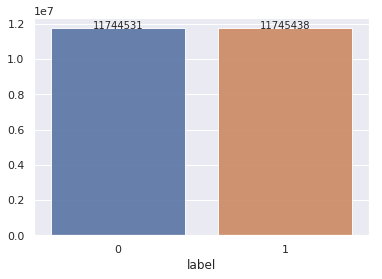

In [22]:
ax = sns.barplot(label_count["label"], label_count["count"].values, alpha=0.9)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1, int(height) ,ha="center")
plt.show()

### Summary Statistics For Integer Variables

As described on the criteo website, variables i1-i13 mostly contain count values in the form of integers. Although we ultimately handle each count as a separate categorical feature, we would like to first inspect the distribution of each of these features.

In [23]:
numeric_features = [t[0] for t in updated_initial_train_df.dtypes if t[1] == 'int']
updated_initial_train_df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
label,23489969,0.5000193061131754,0.5000000102701152,0,1
i1,13772521,3.9781711714217027,10.129203541195555,0,5775
i2,23489969,115.57379083812329,413.9031168541948,-3,36664
i3,18121526,29.900648819530982,496.94918957715873,0,65535
i4,18229461,7.054289098289851,8.536189936069848,0,933
i5,23007452,15440.987463931251,61619.741579073394,0,23159456
i6,19098979,97.79244571136499,329.2849993391173,0,367553
i7,22619808,19.419519829699706,72.15592636789144,0,26297
i8,23480620,12.258109922140045,15.511498923965956,0,6047


### Distribution of Numeric values from a random sample of the train data

As we can see from the data, the distribution of numeric values is skewed, but since we plan to handle these as categorical features we have decided not to log transform these values.

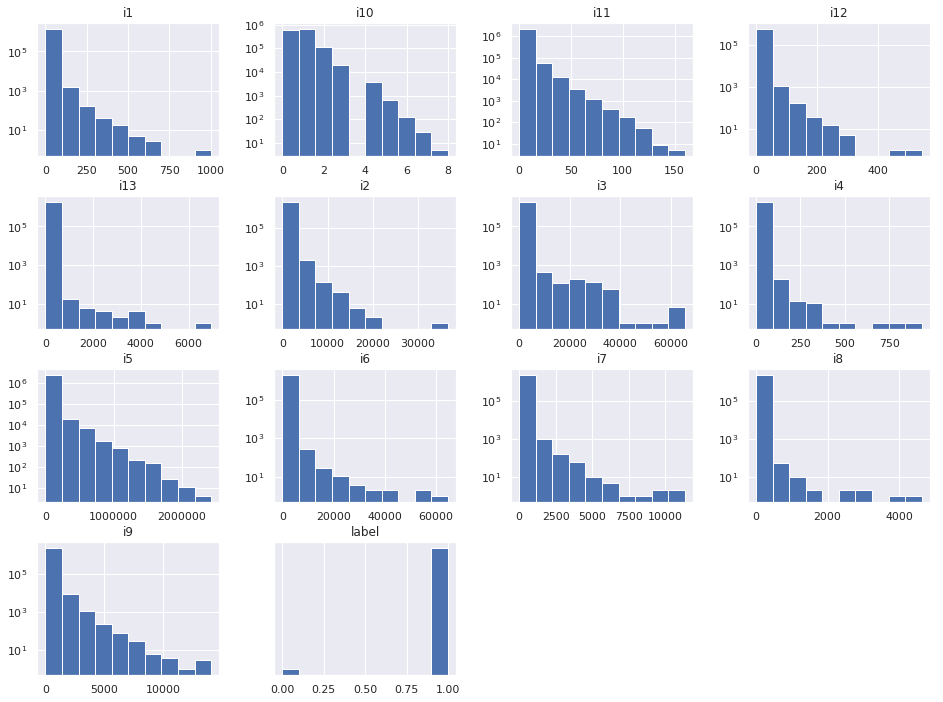

In [24]:
dev_pd_df = dev_df.select("*").toPandas()
dev_pd_df.hist(figsize=(16, 12), log=True)
plt.show()

### Correlations between numeric variables.

We would also like to inspect potential correlations between each of these features. As seen below, there are a few features that seem to be correlated with each other. Although these correlations are not "strong" (e.g. > 0.70), we will investigate the effect of removing some of these features in the model development phase. As of now, features i5, i10, i7, and i8 are candidates for removal.

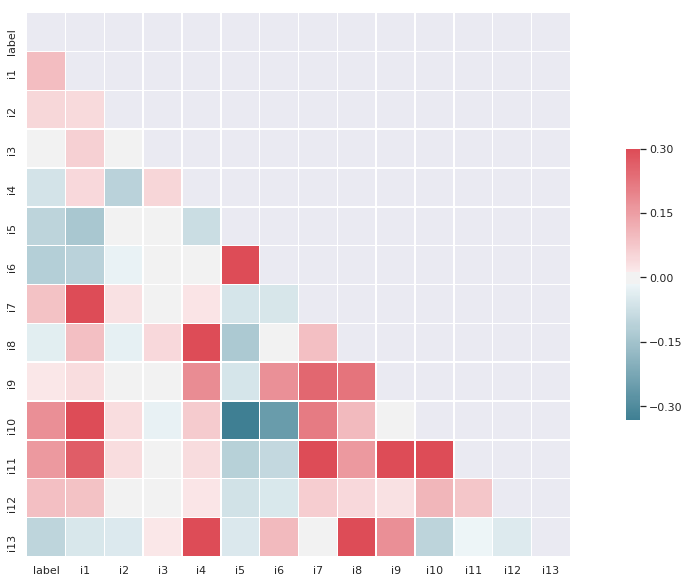

In [25]:
# Compute the correlation matrix
corr = dev_pd_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Identify the null values in the dataset

As described earlier, one of the major challenges with this dataset is understanding what each of these features represent. Upon initial inspection, we found a number of null values scattered about in the dataset, so it was important to get estimates on the total number of null values in each feature.

As seen in the table below, there is a significant number of null values in many of these features. Sometimes, missingness may be predictive of a class, but knowing the data is important in evaluating if this is true for our dataset. Unfortunately, in this dataset we will need to experiment a great deal to see how handling null values affect prediction rates because the data is anonymized. Of note, features such as c32, c33, c38, and c39 may share missing values at the same time. Further EDA is warranted to understand if this is true.

In [26]:
def plot_graph_df(df, add_width, di_height, title= "", label= "df"):
    columns = df.index
    new_df = df["counts"].values

    plt.subplots(figsize=(16, 10))
    graph = sns.barplot(new_df, columns, alpha=0.9)

    for p in graph.patches:
        width = p.get_width()
        height = p.get_height()
        graph.text(width + add_width, p.get_y() + height/di_height, int(width) ,ha="center")

    plt.title(title, fontsize=15)

In [27]:
null_summary_df = updated_initial_train_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in updated_initial_train_df.columns]).toPandas().transpose()
null_summary_df.index.name = "feature"
null_summary_df.columns = ["counts"]

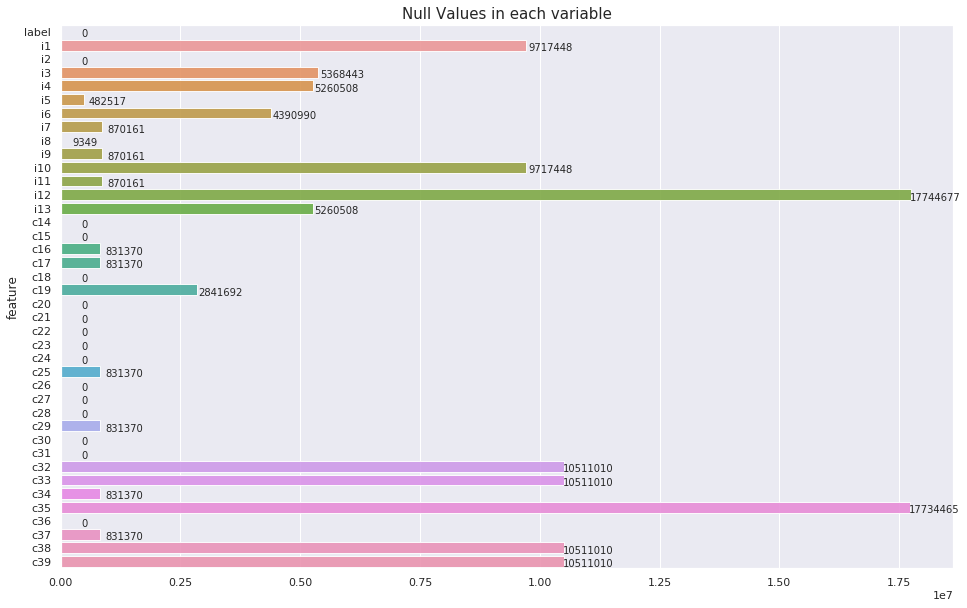

In [28]:
null_df = pd.DataFrame(null_summary_df, columns=null_summary_df.columns)
title = "Null Values in each variable"
plot_graph_df(null_df, 500000, 1., title)

### Unique values of categorical variables

A key decision made during modeling was to handle all values (integers and strings) as categorical features. For this reason, it was important to understand how many unique values each feature contains as this directly affects the number of categories generated in our dataset. Because these data have many implications for downstream decisions, we took time to explore some of the columns that had a significant number of unique features. Of note, although columns such as c16 contains a large number of unique values, there is only a small number of categories that make up the majority of the data. More discussion on this in the feature engineering section. For the purpose of brevity, we have only included the high level summaries here. Of note, c16, c25, c29, and c34 have a large number of unique categories. 

In [32]:
#Fill in null values for c16 in train set
updated_nonull_train_df = updated_initial_train_df.withColumn("c16",
                                             when(updated_initial_train_df["c16"].isNull(),
                                                  lit('nullVal')).otherwise(col("c16")))
#Fill in null values for c34 in train set
updated_nonull_train_df = updated_nonull_train_df.withColumn("c34",
                                             when(updated_nonull_train_df["c34"].isNull(),
                                                  lit('nullVal')).otherwise(col("c34")))

In [33]:
train_unique_summary = updated_nonull_train_df.agg(*(countDistinct(col(c)).alias(c) for c in updated_nonull_train_df.columns)).toPandas().transpose()
train_unique_summary.index.name = "feature"
train_unique_summary.columns = ["counts"]

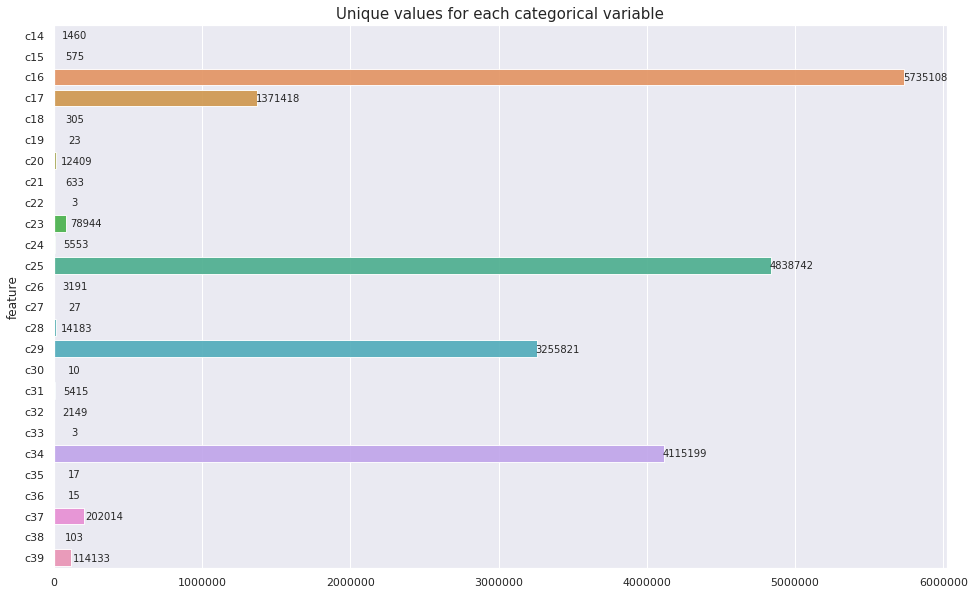

In [34]:
distinct_count_df = pd.DataFrame(train_unique_summary, columns=train_unique_summary.columns).iloc[14:]
title = "Unique values for each categorical variable"
plot_graph_df(distinct_count_df, 140000, 1.4, title)

### Co-occurrence among variables 

Of note, it appears as though there is a relationship between columns c16, c17, c25, c29, and c34. It is very typical that the unique values co occur together (example shown below). We tried to see if combining these columns would result in a better model, but typically observed that AUC and accuracy dropped. Further investigation of these features is warranted, but it is difficult to make any sense of these results given that these data are anonymized.

In [35]:
check = train_df.select("c16","c21","c25","c29","c17", "c34")

check.filter(col("c16") == 'd032c263').show(10)

check.filter(col("c16") == 'd032c263').filter(col("c25")!="dfbb09fb").show(20)

check.filter(col("c16") == 'd032c263').filter(col("c29")!="84898b2a").show(20)

check.filter(col("c16") == 'd032c263').filter(col("c17")!="c18be181").show(20)

+--------+--------+--------+--------+--------+--------+
|     c16|     c21|     c25|     c29|     c17|     c34|
+--------+--------+--------+--------+--------+--------+
|d032c263|0b153874|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|1f89b562|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|0b153874|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|0b153874|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|64523cfa|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|f504a6f4|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|0b153874|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|37e4aa92|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|0b153874|dfbb09fb|84898b2a|c18be181|0014c32a|
|d032c263|51d76abe|dfbb09fb|84898b2a|c18be181|0014c32a|
+--------+--------+--------+--------+--------+--------+
only showing top 10 rows

+---+---+---+---+---+---+
|c16|c21|c25|c29|c17|c34|
+---+---+---+---+---+---+
+---+---+---+---+---+---+

+---+---+---+---+---+---+
|c16|c21|c25|c29|c17|c34|
+---+---+---+---+---+---+
+---+--

We can see that there are a handful of columns that tend to be null together.

In [36]:
checkNulls = train_df.select("i3","c16","c21","c25","c29","c17", "c34").filter(col("c17").isNull())

checkNulls.sample(False,0.01).show()

+----+----+--------+----+----+----+----+
|  i3| c16|     c21| c25| c29| c17| c34|
+----+----+--------+----+----+----+----+
|null|null|0b153874|null|null|null|null|
|null|null|1f89b562|null|null|null|null|
|null|null|37e4aa92|null|null|null|null|
|null|null|0b153874|null|null|null|null|
|null|null|0b153874|null|null|null|null|
|   1|null|1f89b562|null|null|null|null|
|null|null|37e4aa92|null|null|null|null|
|   1|null|0b153874|null|null|null|null|
|  25|null|0b153874|null|null|null|null|
|null|null|0b153874|null|null|null|null|
|  12|null|0b153874|null|null|null|null|
|  16|null|0b153874|null|null|null|null|
|  20|null|0b153874|null|null|null|null|
|   1|null|0b153874|null|null|null|null|
|null|null|0b153874|null|null|null|null|
|   2|null|5b392875|null|null|null|null|
|null|null|0b153874|null|null|null|null|
|null|null|0b153874|null|null|null|null|
|null|null|0b153874|null|null|null|null|
|   2|null|5b392875|null|null|null|null|
+----+----+--------+----+----+----+----+
only showing top

### Feature Engineering

After developing our baseline models (without feature engineering), we began to explore various feature engineering efforts we could undergo to improve model accuracy. As mentioned previously, these data have been anonymized so developing a justification for how to engineer features and handle null values is a bit of a shot in the dark, with basic EDA guiding these decisions. It is also important to note that when we tested the engineered features we only used a subset of the training data (20%) and tested this against a mini dev set (5%). This work is captured in a separate notebooks, but can be summarised here as follows:

**The techniques we tested went as follows:**
* Impute mean or median values for each of the missing entries in the integer variables
* Bin values using QuantileDiscretizer, which handles null values by placing them in their own bin.
* Try setting a cutpoint based on count of unique entries in each features to reduce the "noise" for unique features that don't occur often
* Replace null integer fields with their own value (-10,000).
* Replace null categorical fields with NoValue
* Tested the removal of correlated features or features that seem to capture similar information.

In the section below, we will only include the feature engineering efforts that ultimately led to better AUC when testing on the 5% dev dataset.

### Handling null entries for both categorical and integer values

After testing with many different methods, we found that applying a blanket value of -10,000 for null integer values improved our AUC and accuracies slightly. This implies that the missingness of these values may be predictive in some way. To our surprise, filling null categorical variables hurt our models slightly, expect for when we handled null cases for c16 and c34.

In [37]:
updated_nonull_train_df = updated_initial_train_df.fillna(-10000)

### Setting cut point for c16

In our EDA we identified that c16 has the greatest number of unique categories among any of the features. We tested a number of different methods for handling null values and creating cutpoints in the dataset. The method we landed on that gave the best model performance was to take the counts of each unique feature in the dataset and categorize features as 'other' if their count was less than 90,000. When this feature has a count greater than 90,000, it keeps the category name. 

In [38]:
def plot_average_plot(df, columns, count, column_name, add_width = 0, di_height = 1.5, title= "", label= "df"):
    plt.subplots(figsize=(16, 10))
    graph = sns.barplot(count, columns, alpha=0.9)

    for p in graph.patches:
        width = p.get_width()
        height = p.get_height()
        graph.text(width + add_width, p.get_y() + height/di_height, int(width) ,ha="center")

    plt.title(title, fontsize=15)
    plt.xlabel(column_name , fontsize=15)

In [39]:
averagesc16 = updated_nonull_train_df.groupBy("c16").count().sort(col("count").desc())\
                        .select("c16", col("count").alias("count16"))

df_with_avgs_train = updated_nonull_train_df.join(averagesc16, on="c16")

imputed_df_train_n = df_with_avgs_train\
  .withColumn('c16_new', when(col('count16') >= 90000, df_with_avgs_train['c16']).otherwise('other'))

averagesc16_final = imputed_df_train_n.groupBy("c16_new").count().sort(col("count").desc())\
                        .select("c16_new", col("count"))

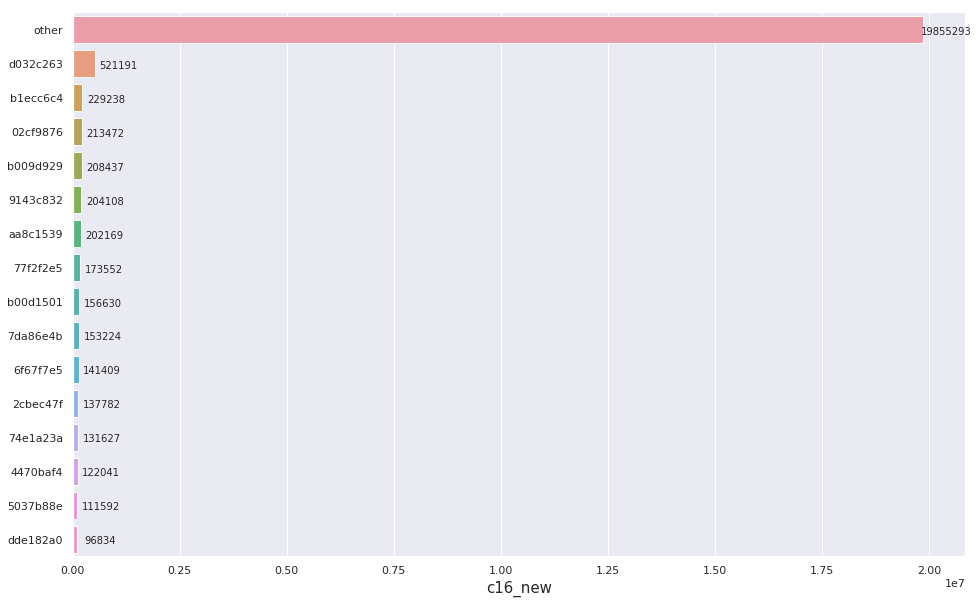

In [40]:
df = averagesc16_final.toPandas()
plot_average_plot(df, df["c16_new"].values, df["count"].values, 'c16_new', 550000)

### Setting cutpoint for c34

We employed the exact same method for c34, which slightly improved accuracy of our models.

In [41]:
averagesc34 = updated_nonull_train_df.groupBy("c34").count().sort(col("count").desc())\
                        .select("c34", col("count").alias("count34"))

df_with_avgs_train = imputed_df_train_n.join(averagesc34, on="c34")

imputed_df_train_n = df_with_avgs_train\
 .withColumn('c34_New',when(col('count34') >= 90000,df_with_avgs_train.c34).otherwise('other'))

averagesc34_final = imputed_df_train_n.groupBy("c34_new").count().sort(col("count").desc())\
                        .select("c34_new", col("count"))

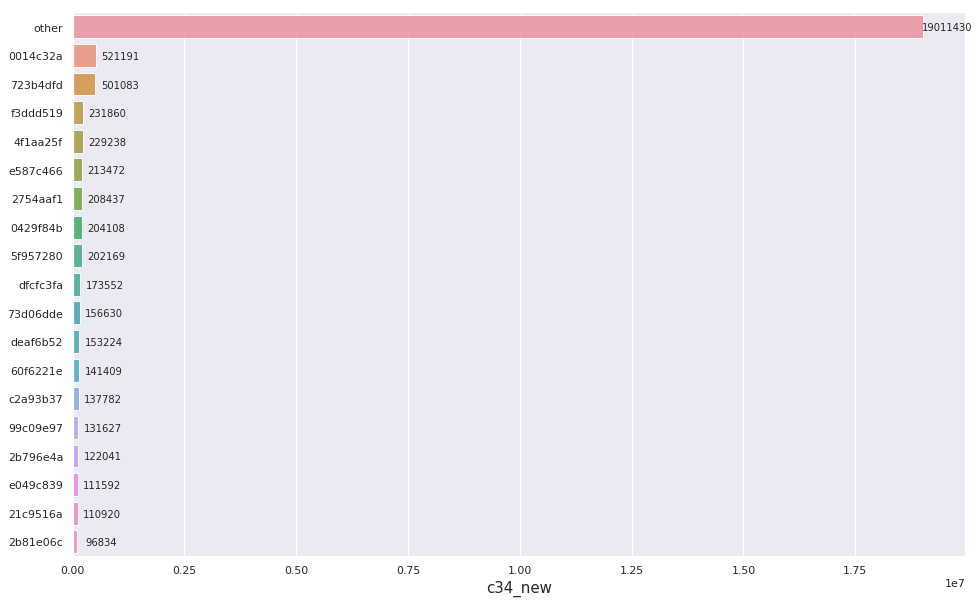

In [42]:
df = averagesc34_final.toPandas()
plot_average_plot(df, df["c34_new"].values, df["count"].values, 'c34_new', 550000)

### Summary of remaining null entries

Understanding the number of null entries that remain is important for the next step of feature engineering, which is to implement FeatureHasher. FeatureHasher takes what would have been a very sparse one hot encoded matrix, and condeses the data down to a dense representation of indices. FeatureHasher ignores null entries when indexing these values.

In [43]:
nonull_summary_df  = updated_nonull_train_df.select([count(when(isnan(c) | col(c).isNull(), c))\
                                                     .alias(c) for c in updated_nonull_train_df.columns])\
                                                     .toPandas().transpose()
nonull_summary_df.index.name = "feature"
nonull_summary_df.columns = ["counts"]

In [44]:
nonull_df = pd.DataFrame(nonull_summary_df, columns=nonull_summary_df.columns)
nonull_df

,counts
feature,
label,0
i1,0
i2,0
i3,0
i4,0
i5,0
i6,0
i7,0
i8,0


### Implement Feature Engineering on Datasets

In preparation for passing the data into the next piece (FeatureHasher), we conduct all of the feature engineering described above.

In [19]:
#Fill NA values for all integer columns. Because the categorical columns are as StringType, these columns
#will be left as null.
train_FE_df = updated_initial_train_df.fillna(-10000)
test_FE_df = initial_test_df.fillna(-10000)

#Fill in null values for c16 in train set
train_FE_sub_NoNull = train_FE_df.withColumn("c16",
                                             when(train_FE_df["c16"].isNull(),
                                                  lit('nullVal')).otherwise(col("c16")))

#Fill in null values for c16 in test set
test_FE_sub_NoNull = test_FE_df.withColumn("c16",
                                             when(test_FE_df["c16"].isNull(),
                                                  lit('nullVal')).otherwise(col("c16")))

#Fill in null values for c34 in train set
train_FE_sub_NoNull = train_FE_sub_NoNull.withColumn("c34",
                                             when(train_FE_sub_NoNull["c34"].isNull(),
                                                  lit('nullVal')).otherwise(col("c34")))

#Fill in null values for c34 in test set
test_FE_sub_NoNull = test_FE_sub_NoNull.withColumn("c34",
                                             when(test_FE_sub_NoNull["c34"].isNull(),
                                                  lit('nullVal')).otherwise(col("c34")))

#Get the count for each unique value in column 16 of train data
counts16 = train_FE_sub_NoNull.groupBy("c16").count().sort(col("count").desc())\
                        .select("c16",col("count").alias("count16"))

#Get the count for each unique value in column 34 of train data
counts34 = train_FE_sub_NoNull.groupBy("c34").count().sort(col("count").desc())\
                        .select("c34",col("count").alias("count34"))

#Join the associated counts for c16 on the train data
train_FE_sub_NoNull = train_FE_sub_NoNull.join(counts16, on="c16")

#Join the associated counts for c16 on the test data
test_FE_sub_NoNull = test_FE_sub_NoNull.join(counts16, on="c16")

#Create the new feature to generate cutoffs for when a unique value has a low count
train_FE_sub_NoNull = train_FE_sub_NoNull\
  .withColumn('c16_New',when(col('count16') >= 90000,train_FE_sub_NoNull.c16).otherwise('other'))

#Create the new feature to generate cutoffs for when a unique value has a low count
test_FE_sub_NoNull = test_FE_sub_NoNull\
  .withColumn('c16_New',when(col('count16') >= 90000,test_FE_sub_NoNull.c16).otherwise('other'))

#Join the associated counts for c34 on the train data
train_FE_sub_NoNull = train_FE_sub_NoNull.join(counts34, on="c34")

#Join the associated counts for c34 on the test data
test_FE_sub_NoNull = test_FE_sub_NoNull.join(counts34, on="c34")

#Create the new feature to generate cutoffs for when a unique value has a low count
train_FE_sub_NoNull = train_FE_sub_NoNull\
 .withColumn('c34_New',when(col('count34') >= 90000,train_FE_sub_NoNull.c34).otherwise('other'))

#Create the new feature to generate cutoffs for when a unique value has a low count
test_FE_sub_NoNull = test_FE_sub_NoNull\
 .withColumn('c34_New',when(col('count34') >= 90000,test_FE_sub_NoNull.c34).otherwise('other'))

#Use Quantile Discretizer to bin values in i5 into 200 bins
qds = QuantileDiscretizer(numBuckets=200, inputCol="i5", outputCol="i5_bin", relativeError=0.01, handleInvalid="error")

#fit the data and identify optimal splits
bucketizer = qds.fit(train_FE_sub_NoNull)

imputed_df_train = bucketizer.transform(train_FE_sub_NoNull).cache()
imputed_df_test = bucketizer.transform(test_FE_sub_NoNull).cache()

We split the imputed training dataset into 70% training data, 10% dev, and 20% test set to feed into the feature hasher.

In [21]:
#Make train dev split from the data
train_df, dev_df, test_df = imputed_df_train.randomSplit([0.7,0.1,0.2], seed = 2019)

#Count number of entries
train_df.count()

16442235

In [22]:
train_df.show(3)

+--------+--------+-----+------+---+------+------+------+------+------+---+------+------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+------+
|     c34|     c16|label|    i1| i2|    i3|    i4|    i5|    i6|    i7| i8|    i9|   i10|   i11|   i12|   i13|     c14|     c15|     c17|     c18|     c19|     c20|     c21|     c22|     c23|     c24|     c25|     c26|     c27|     c28|     c29|     c30|     c31|     c32|     c33|     c35|     c36|     c37|     c38|     c39|count16|c16_New|count34|c34_New|i5_bin|
+--------+--------+-----+------+---+------+------+------+------+------+---+------+------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----

In [23]:
#Count number of entries
dev_df.count()

2349954

### FeatureHasher

In our implementation of logistic regression, we are treating all variables as categorical variables (including integers). As shown in our EDA section, many of the features take on a wide variety of unique values with some features having as many as 5,000,000 unique values. If we were to one-hot encode these data we would have a very large sparse matrix. Although our feature engineering efforts have reduced the number of unique features down substantially, we would need massive amounts of memory to store and work with this sparse matrix. FeatureHasher takes care of the sparsity problem by providing indices for a column where a feature would have normally taken on a value of 1. This is very good for our RDD implementation because this means that all we need to do is broadcast the weight vector and use the subsequent indices from FeatureHasher to pull the relevant weights for making our predictions. 

FeatureHasher implements the hashing trick using MurmumHash. What this does is it assigns each unique feature a value between 1 and the number of features you would like to hash to. FeatureHasher's default number is 262,144. FeatureHasher will then take the modulo of the unique feature, and then this will be the indice for the "column" in which the feature would have had a value of 1.0 in the one-hot encoded matrix. The number of features we hash to is a parameter that needs to be tuned because this directly affects the number of collisions that may occur in the dataset. What this means is that if we do not choose an appropriate number for the hash function to hash to, there may be a large number of different features that map back to the same indice. Although a small number of collisions may be tolerable, a large number of collisions may adversely affect our results. After experimentation, we found that about 1 million features is an optimal number of features to hash to. This comes as a slight surprise given the number of unique values we have in our dataset. This may be due to a few reasons. For one, forcing a number of collisions may reduce the amount of "noise" our models would otherwise try to normally fit. It could also be because our models are underfitting and we need to train the models for longer. More experimentation is required.

For the purpose of this project, we partitioned the training data into three datasets. These datasets include the training set (70%), dev set (10%), and test set (20%).

In [81]:
columnNames = ["i1","i2","i3","i4","i5_bin","i6","i7","i8", "i9","i10",
               "i11","i12","i13","c14","c15","c16_New","c17","c18",
               "c19","c20","c21","c22","c23","c24","c25","c26","c27",
               "c28","c29","c30","c31","c32","c33","c34_New","c35",
               "c36","c37","c38"]


hasher_FE = FeatureHasher(numFeatures=262144*4,
                             inputCols=columnNames,
                             outputCol="features",
                             categoricalCols=columnNames)

columnNames_base = ["i1","i2","i3","i4","i5","i6","i7","i8", "i9","i10",
               "i11","i12","i13","c14","c15","c16","c17","c18",
               "c19","c20","c21","c22","c23","c24","c25","c26","c27",
               "c28","c29","c30","c31","c32","c33","c34","c35",
               "c36","c37","c38"]

hasher_Base = FeatureHasher(numFeatures=262144*4,
                            inputCols=columnNames_base,
                            outputCol="features",
                            categoricalCols=columnNames_base)

@udf("array<integer>")
def get_indices(v):
    return v.indices.tolist()

#Run a split on the basic dataset with no feature engineering
train_df_base, dev_df_base, test_df_base = updated_initial_train_df.randomSplit([0.7,0.1,0.2], seed = 2019)

#Version with Feature Engineering
_featurized_train_df = hasher_FE.transform(train_df).select('label','features')
featurized_train_df = _featurized_train_df.select('label',get_indices('features'))

#Baseline Version (No Feature Engineering)
_featurized_train_df_base = hasher_Base.transform(train_df_base).select('label','features')
featurized_train_df_base = _featurized_train_df_base.select('label',get_indices('features'))

#Version with Feature Engineering
_featurized_dev_df = hasher_FE.transform(dev_df).select('label','features')
featurized_dev_df = _featurized_dev_df.select('label',get_indices('features'))

#Baseline Version (No Feature Engineering)
_featurized_dev_df_base = hasher_Base.transform(dev_df_base).select('label','features')
featurized_dev_df_base = _featurized_dev_df_base.select('label',get_indices('features'))


#Small 20% Test Data
#Version with Feature Engineering
_featurized_test_df_local = hasher_FE.transform(test_df).select('label','features')
featurized_test_df_local = _featurized_test_df_local.select('label',get_indices('features'))

#Baseline Version (No Feature Engineering)
_featurized_test_df_base_local = hasher_Base.transform(test_df_base).select('label','features')
featurized_test_df_base_local = _featurized_test_df_base_local.select('label',get_indices('features'))

#Full test data
#Version with Feature Engineering
_featurized_test_df = hasher_FE.transform(imputed_df_test).select('features')
featurized_test_df = _featurized_test_df.select(get_indices('features'))

#Baseline Version (No Feature Engineering)
_featurized_test_df_base = hasher_Base.transform(initial_test_df).select('features')
featurized_test_df_base = _featurized_test_df_base.select(get_indices('features'))

#Full train data
#Version with Feature Engineering
_featurized_train_df_base_full = hasher_FE.transform(imputed_df_train).select('label','features')
featurized_train_df_base_full = _featurized_train_df_base_full.select('label',get_indices('features'))

#Toy dataset to pass through RDD implementation
featurized_toy_df = featurized.select('label',get_indices('features'))

featurized_train_df_base.show(3,truncate=False)
featurized_train_df.show(3,truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|get_indices(features)                                                                                                                                                                                                                                                 |
+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[155497, 159573, 172069, 204993, 232054, 285593, 298493, 303539, 307231, 320614, 333468, 435767, 447486, 479757, 539916, 581058, 597497, 678797, 683045, 746724, 752588, 762590, 822

## 4. Homegrown Scalable Algorithm Implementation
In this section, we implement an RDD version of LogisticRegression using stochastic gradient descent. We leverage the indices generated by FeatureHasher to get the weights from the broadcasted list of weights for our prediction and subsequent sigmoid. For the purpose training our model, we use 70% of the training set provided by Criteo. We then run our development using the 10% dataset, and then test against our 20% test set.

### Implementing The RDD Version
Convert the dataframes into an RDD

In [68]:
featurized_toy_RDD = featurized_toy_df.rdd.map(tuple)

#Baseline Models
featurized_dev_RDD_base = featurized_dev_df_base.rdd.map(tuple)
featurized_train_RDD_base = featurized_train_df_base.rdd.map(tuple)
featurized_test_RDD_base_local = featurized_test_df_base_local.rdd.map(tuple)

#Version w/ Feature Engineering
featurized_dev_RDD = featurized_dev_df.rdd.map(tuple)
featurized_train_RDD = featurized_train_df.rdd.map(tuple)
featurized_test_RDD_local = featurized_test_df_local.rdd.map(tuple)

#full train and full test
featurized_test_RDD = featurized_test_df.rdd.map(tuple)
featurized_test_RDD_base = featurized_test_df_base.rdd.map(tuple)

featurized_train_RDD_full = featurized_train_df_base_full.rdd.map(tuple)

#### Calculate The Sigmoid

In [27]:
def sigmoid(x):
    '''
    Calculate the sigmoid

    Args:
        x (float):  Results of the pseudo dot product of model weights 

    Return:
        p(float):   Returning a bounded probability to avoid underflow issues.
    '''

    #Check that the dot product is a positive value
    if x >= 0: 
        #Calculate sigmoid
        p = 1 / (1 + exp(-x)) 
    else:
        #Calculate sigmoid
        p = exp(x) / (1 + exp(x))

    #Bound the prediction to avoid underflow
    return max(min(p, 1. - 10e-12), 10e-12) 

#### Calculate The Prediction

In [28]:
#Calculate the predicted value 
def _calc_prediction(payload,broad,dev = False, train=True):
    '''
    Because we are dealing with sparse matrices we are leveraging FeatureHasher,
    which provides a dense representation of the column indices in which our categorical
    variables have a value of 1.0. This index is used to map back to the vector of weights
    that is broadcasted. We add each individual weight, which is equivalent to obtaining
    the scalar value from the dot product of x values and the weight vector.

    Args:
        payload(tuple):         This is a tuple that includes the label, and hashed indices

    Return:
        key value pair (tuple): label and hashed indices as a key, 
                                and associated prediction as a value

    '''
    #Check if we are getting the predictions for training.
    if train:
        #Unpack the payload
        label,hashFeats = payload

        #Get the broadcasted weights
        #weight = modelWeights.value
        weight = broad.value
        #Add the bias term in position 0
        modelW = weight[0]

        #Iterate through the feature indices
        for index in hashFeats:
            #Add the model weights * x (which is always 1.0)
            #We add 1 to the index to ensure that there will never be collisions with the bias
            modelW += weight[index+1] * 1.0

        #Get the predicted probability based on the pseduo dot product of the weights and x values
        p = sigmoid(modelW)

        #Return key: label and feature indexes, valule: prediction
        return ((label,hashFeats), float(p))
    
    #If predicting on test
    else:
        
        if dev == True:
        #Unpack the payload
            label,hashFeats = payload
            
        else:
            hashFeats = payload

        #Get the broadcasted weights
        #weight = modelWeights.value
        weight = broad.value
        #Add the bias term in position 0
        modelW = weight[0]

        #Iterate through the feature indices
        for index in hashFeats:
            #Add the model weights * x (which is always 1.0)
            #We add 1 to the index to ensure that there will never be collisions with the bias
            modelW += weight[index+1] * 1.0

        #Get the predicted probability based on the pseduo dot product of the weights and x values
        p = sigmoid(modelW)

        #Return key: label and feature indexes, valule: prediction
        return (hashFeats, float(p))

#### Calculate Logloss

In [29]:
#Calculate the logloss
def _calc_loss(labelHash):
    '''
    Calculate the logloss

    Args:
        labelHash (tuple):     key: label, feature indices; value: predicted probability

    Return:
        loss(float): logloss
    '''     
    #unpack the keys
    label, Hash = labelHash[0]

    #unpack the value
    p = labelHash[1]

    #Compute logloss according to label
    if label == 1:
        loss = -log(p)

    else:
        loss = -log(1-p)

    #Return loss
    return(loss)

#### Logistic Regression

In [47]:
def RunRDDLogistic(model, featRDD, devRDD, lrnRate = 0.05, nIter = 10, verbose = True, regType="None", regParam=0.05):
    '''
    This function runs logistic regression using RDDs.
    
    Args:
            model(list):     model weights (either trained or initialized to 0.0)
            featRDD:         Featurized RDD from FeatureHasher outputs
            devRDD:          Featurized RDD from FeatureHasher outputs
            regType(string): Define regularization to use
            regParam(float): Define regularization parameter
            lrnRate(float):  Learning rate (alpha)
            nIter(int):      Number of training iterations to undergo
            verbose(bool):   Returns the logloss

    Return:
            modelWeights(list): list of model weights
    '''
    
    #Update the Gradient
    def _calc_grad(labelHash, regType=regType, regParam=regParam):
        '''
        This function takes in the composite key value pair and calculates the gradient update
        that is needed for each row of data. This is emitted as an index, gradient key value pair
        for the combineByKey step so that we can update the model weights.
        
        Args:
            labelHash (tuple):     key: label, feature indices; value: predicted probability

        Return:
            loss(float): logloss        
        '''
        #Get the label and hashed indices
        label, Hash = labelHash[0]
        
        #Get the prediction
        p = labelHash[1]
        
        #Get the learning rate
        a = alpha.value
        
        # get the weights, drop bias term
        w = modelWeights.value
        
        # calc the grad
        grad = a*(p-label)
        
        #Handle the bias term and yield the gradient
        yield(0, grad) 

        for index in Hash:
            if regType.lower() == 'lasso':
                # calculate lasso
                reg_term = regParam * np.sign(w[index+1])
                # add to grad
                grad += reg_term
            elif regType.lower() == 'ridge':
                # calculate ridge
                reg_term = regParam * w[index+1] * 2
                # add to grad
                grad += reg_term
            #Yield the gradient for each index (feature) to be updated
            #We add one to map back to the appropriate location in the model weights
            yield(index + 1, grad)
    
    #Broadcast the model weights
    modelWeights = sc.broadcast(model)
    
    #Broadcast the learning rate
    alpha = sc.broadcast(lrnRate)
    
    #Broadcast the total number of rows in the dataset
    m = sc.broadcast(featRDD.count())
    
    start = time.time()
    
    #Keep track of loss for graphing
    loss_history = []
    dev_loss = []
    
    #Iterate through number of times.
    for i in range(nIter):
        start_int = time.time()
        #Get the predicted values based on current model weights
        interimResults = featRDD.map(lambda x: _calc_prediction(x, modelWeights)).cache()
        
        #Calculate logloss
        calculatedLoss = interimResults.map(lambda x:_calc_loss(x)).mean()
        
        #append loss
        loss_history.append(calculatedLoss)
        
        #Get the predicted values based on current model weights
        interimResults_dev = devRDD.map(lambda x: _calc_prediction(x, modelWeights)).cache()
        
        #Calculate logloss
        calculatedLoss_dev = interimResults_dev.map(lambda x:_calc_loss(x)).mean()
        
        #append loss
        dev_loss.append(calculatedLoss_dev)
        
        #Print if desired
        if verbose:
            print('Logloss on step {} = {}'.format(i+1,calculatedLoss))
        else:
            if (i+1)%5 == 0:
                print('Logloss on step {} = {}'.format(i+1,calculatedLoss))
        
        #Calculate gradient updates for each feature
        #Combine the gradients for each feature
        #Normalize to get mean gradient update for each feature
        updateWeights = interimResults.flatMap(_calc_grad)\
                                      .combineByKey(lambda x: x,
                                                    lambda m1, m2: m1 + m2,
                                                    lambda c1, c2: c1 + c2)\
                                      .mapValues(lambda x: x/m.value).collect()
        
        #Get current model weights
        modWeights = modelWeights.value
        
        #Iterate through the index and weight for each feature
        for index, weight in updateWeights:
            
            #Update weights accordingly
            modWeights[index] -= weight

        #Broadcast new weights
        modelWeights = sc.broadcast(modWeights)
        
        if verbose:
            print(f"... trained Logistic Regression round {i + 1} in {time.time() - start_int} seconds\n")
            
        else:
            if (i+1)%5 == 0:
                print(f"... trained Logistic Regression round {i + 1} in {time.time() - start_int} seconds\n")
        
    print(f"\n... trained whole Logistic Regression in {time.time() - start} seconds")
    
    #Return model weights.
    return modelWeights.value, loss_history, dev_loss

#### Run The Toy Example

In [40]:
D = 2 ** 21
BASELINE = [0.0, ]*D
model_toy_weights, toy_loss, _ = RunRDDLogistic(BASELINE,featurized_toy_RDD,featurized_toy_RDD,
                                                nIter = 3,verbose = False)

Logloss on step 1 = 0.6931471805599453

... trained Logistic Regression round 1 in 1.4513304233551025 seconds

... trained Logistic Regression round 2 in 1.2800874710083008 seconds

... trained Logistic Regression round 3 in 1.220613718032837 seconds

... trained whole Logistic Regression in 3.952463150024414 seconds


As you can see the logloss we compute from our toy data set matches the hand calculations we did!

#### Run The Train Data - Baseline

In [43]:
D = 2 ** 21
BASELINE = [0.0, ] * (D)
model_train_weights_base, train_loss_base, dev_loss_base = RunRDDLogistic(BASELINE,featurized_train_RDD_base, 
                                                           featurized_dev_RDD_base, nIter = 40, lrnRate = 0.1,
                                                           verbose = True)

Logloss on step 1 = 0.6931471805599453

... trained whole Logistic Regression in 8594.590517282486 seconds


##### Save model

In [48]:
model_train_weights_base_save = np.array(model_train_weights_base)
np.save('train_weights_40iter_baseline.npy', model_train_weights_base_save)

In [49]:
!gsutil cp 'train_weights_40iter_baseline.npy' gs://lance_miles_w261/notebooks/train_weights_40iter_baseline.npy

Copying file://train_weights_40iter_baseline.npy [Content-Type=application/octet-stream]...
- [1 files][ 16.0 MiB/ 16.0 MiB]                                                
Operation completed over 1 objects/16.0 MiB.                                     


#### Run The Train Data - Feature Engineering

In [51]:
D = 2 ** 21
BASELINE = [0.0, ] * D
model_train_weights, train_loss, dev_loss = RunRDDLogistic(BASELINE,featurized_train_RDD,
                                                 featurized_dev_RDD, nIter = 40, lrnRate = 0.1,
                                                 verbose = False)

Logloss on step 1 = 0.6931471805599454

... trained whole Logistic Regression in 9689.209838151932 seconds


In [54]:
model_train_weights_save = np.array(model_train_weights)
np.save('train_weights_40iter.npy', model_train_weights_save)

In [ ]:
!gsutil cp 'train_weights_40iter.npy' gs://lance_miles_w261/notebooks/train_weights_40iter.npy

#### Run FE Train for More Iterations

In [52]:
model_train_140weights, train_140loss, dev_140loss = RunRDDLogistic(model_train_weights,featurized_train_RDD,
                                                 featurized_dev_RDD, nIter = 100, lrnRate = 0.1,
                                                 verbose = False)

Logloss on step 1 = 0.6559010776051641
... trained Logistic Regression round 1 in 233.05305671691895 seconds

... trained Logistic Regression round 2 in 344.4873766899109 seconds

... trained Logistic Regression round 3 in 215.90211582183838 seconds

... trained Logistic Regression round 4 in 213.1689417362213 seconds

... trained Logistic Regression round 5 in 217.383944272995 seconds

Logloss on step 6 = 0.6534416929689876
... trained Logistic Regression round 6 in 238.58427023887634 seconds

... trained Logistic Regression round 7 in 284.98989605903625 seconds

... trained Logistic Regression round 8 in 313.2251625061035 seconds

... trained Logistic Regression round 9 in 245.4842836856842 seconds

... trained Logistic Regression round 10 in 220.52874493598938 seconds

Logloss on step 11 = 0.6512319323244995
... trained Logistic Regression round 11 in 210.99520587921143 seconds

... trained Logistic Regression round 12 in 212.53867292404175 seconds

... trained Logistic Regression r

In [55]:
model_train_140weights_save = np.array(model_train_140weights)
np.save('train_weights_140iter.npy', model_train_140weights_save)

In [56]:
!gsutil cp 'train_weights_140iter.npy' gs://lance_miles_w261/notebooks/train_weights_140iter.npy

Copying file://train_weights_140iter.npy [Content-Type=application/octet-stream]...
- [1 files][ 16.0 MiB/ 16.0 MiB]                                                
Operation completed over 1 objects/16.0 MiB.                                     


#### Train Additional Rounds

In [ ]:
model_train_300weights, train_300loss, dev_300loss = RunRDDLogistic(model_train_140weights,featurized_train_RDD,
                                                 featurized_dev_RDD, nIter = 160, lrnRate = 0.1,
                                                 verbose = False)

In [ ]:
model_train_300weights_save = np.array(model_train_300weights)
np.save('train_weights_300iter.npy', model_train_300weights_save)

In [ ]:
!gsutil cp 'train_weights_300iter.npy' gs://lance_miles_w261/notebooks/train_weights_300iter.npy

### Mini-Batch Gradient Descent

Based on the results of the batch gradient descent, above, we see that training time is very long, and the accuracy improvements are nominal when training on 40 versus 140 epochs (data discussed below in next section). For this reason, we wanted to implement our own mini-batch gradient descent using RDDs to see if we can get the model parameters to converge faster. The primary difference between batch and mini-batch gradient descent is that with batch gradient descent we update the weights, once, after the model has gone through and calculated predictions on all rows within the data. In mini-batch, we create partitions of the RDD, run predictions on each partition, and update the weights with each partition. The batch size is yet another parameter that needs to be tuned in our model. Mini-batch offers a few slightly distinct advantages over the batch gradient descent method. For one, because weights are updated more frequently it allows for the model to avoid local minima. For the purpose of experimentation, we are testing partitioning the data into 20 partitions. 

Another important piece is that the reduce step is expensive in this computation. Each time we reduce, we need to update weights and broadcast them again. With 20 partitions, and 5 iterations, this would be 100 reduce tasks. Efficiencies gained from mini-batch gradient descent may be lost with too many partitions of the data.

In [132]:
def miniBatchLogistic(model, featRDD, devRDD, lrnRate=0.1, 
                      nIter=10, verbose=True, regType="None", 
                      regParam=0.1, batches = 20):
    '''
    This function runs logistic regression using mini-batch gradient descent on RDDs.
    
    Args:
            model(list):     model weights (either trained or initialized to 0.0)
            featRDD:         Featurized RDD from FeatureHasher outputs
            devRDD:          Featurized RDD from FeatureHasher outputs
            regType(string): Define regularization to use
            regParam(float): Define regularization parameter
            lrnRate(float):  Learning rate (alpha)
            nIter(int):      Number of training iterations to undergo
            verbose(bool):   Returns the logloss

    Return:
            modelWeights(list): list of model weights
    '''
    
    #Update the Gradient
    def _calc_grad(labelHash, regType=regType, regParam=regParam):
        '''
        This function takes in the composite key value pair and calculates the gradient update
        that is needed for each row of data. This is emitted as an index, gradient key value pair
        for the combineByKey step so that we can update the model weights.
        
        Args:
            labelHash (tuple):     key: label, feature indices; value: predicted probability

        Return:
            loss(float): logloss        
        '''
        #Get the label and hashed indices
        label, Hash = labelHash[0]
        
        #Get the prediction
        p = labelHash[1]
        
        #Get the learning rate
        a = alpha.value
        
        # get the weights, drop bias term
        w = modelWeights.value
        
        # calc the grad
        grad = a*(p-label)
        
        #Handle the bias term and yield the gradient
        yield(0, grad) 

        for index in Hash:
            if regType.lower() == 'lasso':
                # calculate lasso
                reg_term = regParam * np.sign(w[index+1])
                # add to grad
                grad += reg_term
            elif regType.lower() == 'ridge':
                # calculate ridge
                reg_term = regParam * w[index+1] * 2
                # add to grad
                grad += reg_term
            #Yield the gradient for each index (feature) to be updated
            #We add one to map back to the appropriate location in the model weights
            yield(index + 1, grad)
    
    #Broadcast the model weights
    modelWeights = sc.broadcast(model)
    
    #Broadcast the learning rate
    alpha = sc.broadcast(lrnRate)
    
    #Broadcast the total number of rows in the dataset
    m = sc.broadcast(featRDD.count())
    
    start = time.time()
    
    #Keep track of loss for graphing
    loss_history = []
    dev_loss = []
    
    #Partition the RDD for mini-batch gradient descent
    frac = 1.0/batches
    
    parts = [frac,] * batches
    
    partitionedRDD = featRDD.randomSplit(weights=parts, seed=2019)
    
    #Iterate through number of times.
    for i in range(nIter):
        start_int = time.time()
        partCount = 1
        for partRDD in partitionedRDD:
            #print('.. Beginning partition {}..\n'.format(partCount))
            #Get the predicted values based on current model weights
            interimResults = partRDD.map(lambda x: _calc_prediction(x, modelWeights)).cache()

            #Calculate logloss
            calculatedLoss = interimResults.map(lambda x:_calc_loss(x)).mean()

            #append loss
            loss_history.append(calculatedLoss)


            #Get the predicted values based on current model weights
            interimResults_dev = devRDD.map(lambda x: _calc_prediction(x, modelWeights)).cache()

            #Calculate logloss
            calculatedLoss_dev = interimResults_dev.map(lambda x:_calc_loss(x)).mean()

            #append loss
            dev_loss.append(calculatedLoss_dev)


            #Print if desired
            if verbose:
                print('Logloss on step {} of partition {} = {}'.format(i+1,partCount,calculatedLoss))

            else:
                if partCount%5 == 0:
                    if (i+1)%3 == 0:
                        print('Logloss on step {} partition {} = {}'.format(i+1,partCount,calculatedLoss))

            #Calculate gradient updates for each feature
            #Combine the gradients for each feature
            #Normalize to get mean gradient update for each feature
            updateWeights = interimResults.flatMap(_calc_grad)\
                                          .combineByKey(lambda x: x,
                                                        lambda m1, m2: m1 + m2,
                                                        lambda c1, c2: c1 + c2)\
                                          .mapValues(lambda x: x/m.value).collect()

            #Get current model weights
            modWeights = modelWeights.value

            #Iterate through the index and weight for each feature
            for index, weight in updateWeights:

                #Update weights accordingly
                modWeights[index] -= weight

            #Broadcast new weights
            modelWeights = sc.broadcast(modWeights)
            
            partCount += 1
            
            if verbose:
                print(f"... trained Logistic Regression round {i + 1} in {time.time() - start_int} seconds\n")

            else:
                if (i+1)%5 == 0:
                    print(f"... trained Logistic Regression round {i + 1} in {time.time() - start_int} seconds\n")
        
    print(f"\n... trained whole Logistic Regression in {time.time() - start} seconds")
    
    #Return model weights.
    return modelWeights.value, loss_history, dev_loss

#### Run Mini-Batch Gradient Descent

As seen below, our implementation of mini-batch gradient descent takes a long time to go through 5 iterations. This is because of the number of reduce steps this job has to go through. Unfortunately, we chose a low regularization parameter (0.05), which made the effect of regularization fairly small. Increasing the regularization parameter and reducing the number of batches may reduce the computation time and increase how quickly the model begins to converge.

In [133]:
D = 2 ** 21
BASELINE = [0.0, ] * D
model_train_weights_mini, train_loss_mini, dev_loss_mini = miniBatchLogistic(BASELINE,
                                                 featurized_train_RDD, featurized_dev_RDD, 
                                                 regType="Ridge", nIter = 5, lrnRate = 0.1,
                                                 verbose = False, batches = 20,regParam=0.1)

Logloss on step 5 partition 20 = 0.6865520735988625
... trained Logistic Regression round 5 in 3852.719358444214 seconds


... trained whole Logistic Regression in 19007.952979803085 seconds


### Plot Losses

Now that we have gone through and ran the RDD implementation, we would like to compare train and dev losses.

In [45]:
# plot error curves - RUN THIS CELL AS IS
#Code taken from W261 Teaching Staff - Homework Assignment 4
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Dev Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Logloss')
    if title:
        plt.title(title)
    plt.show()

#### Loss of Train vs Dev on Baseline Model

As we can see from the loss curve, below, we have not yet converged on optimal model parameters. The training loss and dev loss have improved, but not substantially. Increasing learning rate will help the model converge faster, but may also introduce more error and noise into our predictions.

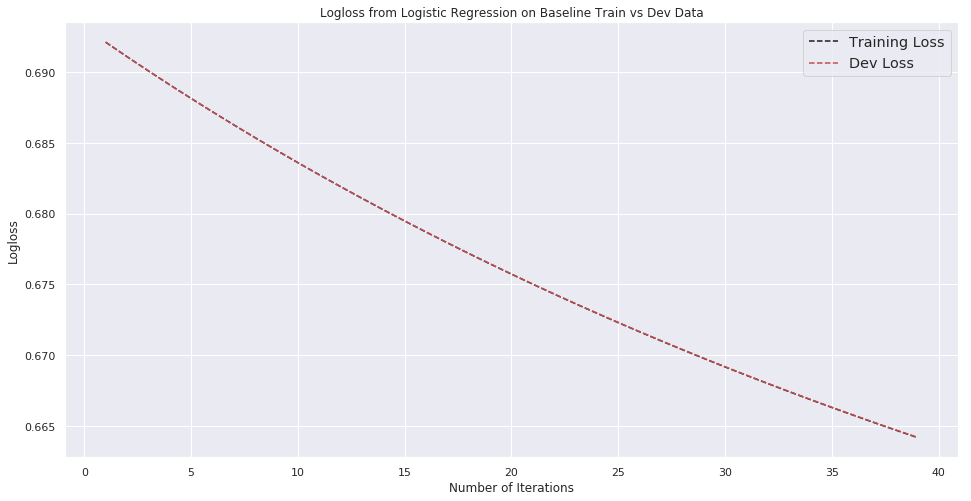

In [46]:
plotErrorCurves(train_loss_base, dev_loss_base, 
                title = 'Logloss from Logistic Regression on Baseline Train vs Dev Data' )

#### Logloss of Train vs Dev on Model Trained with FE Data

As we can see from the plot, below, our logloss seems to be converging slightly faster after 40 iterations for the model trained on data that has engineered features. We still need to train more epochs, but this seems promising relative to the baseline models.

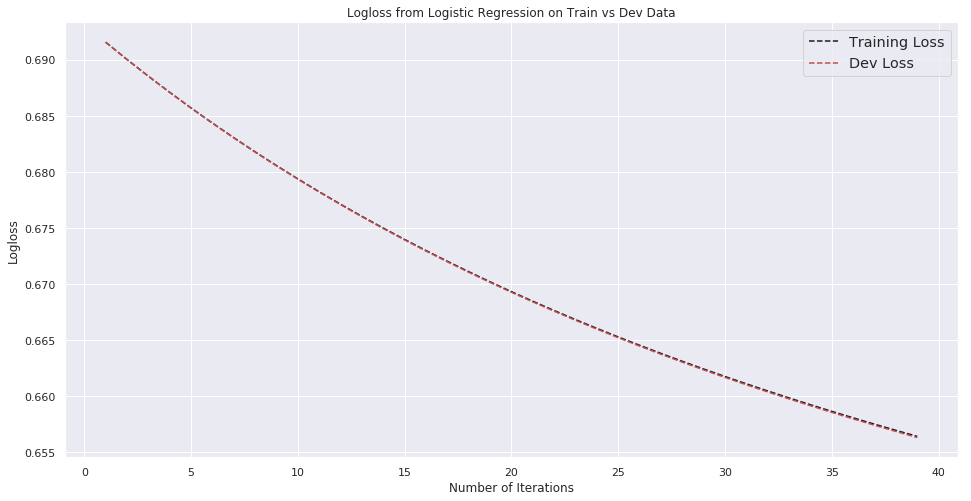

In [57]:
plotErrorCurves(train_loss, dev_loss, 
                title = 'Logloss from Logistic Regression on Train vs Dev Data' )

#### Logloss of Train vs Dev on Model Trained with FE Data After 140 Iterations

We continued training our model for a total of 140 iterations using the dataset that includes feature engineering. As seen below, the curve is begininng to plateau slightly. Although our model should still train longer, it is apparent that more feature engineering or regularization will be needed to obtain substantial gains in logloss.

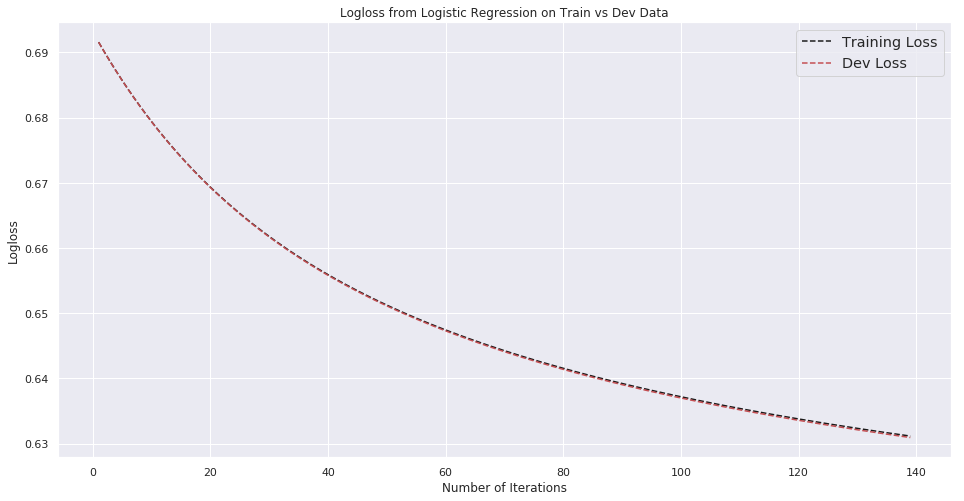

In [59]:
plotErrorCurves((train_loss+ train_140loss), (dev_loss + dev_140loss), 
                title = 'Logloss from Logistic Regression on Train vs Dev Data' )

#### Logloss of Train vs Dev Mini-Batch Gradient Descent w/ L2 Regularization

Below, we show the training and dev loss for our model trained for 5 iterations using mini batch gradient descent. The learning rate was set to 0.1, and the regularization parameter was set to 0.05. Although the regularization parameter is low, we can see that the logloss is gradually declining towards it's local minima.

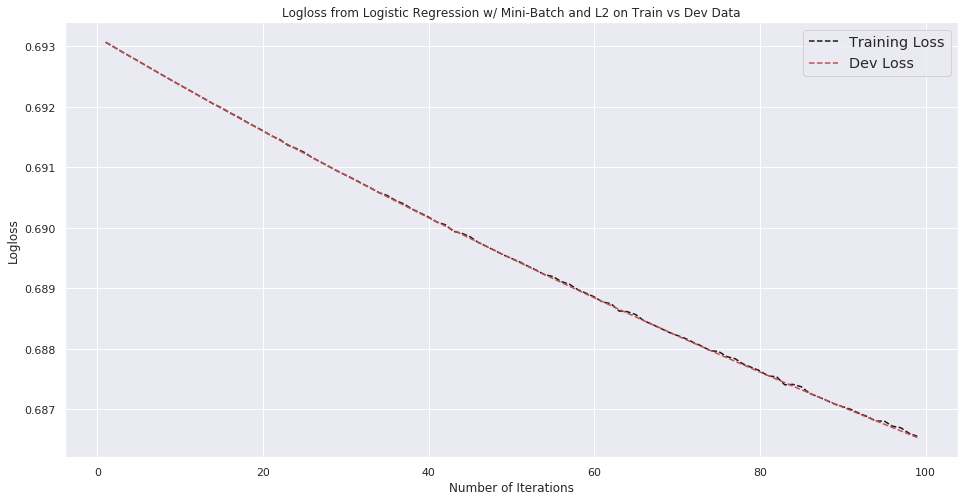

In [134]:
plotErrorCurves((train_loss_mini), (dev_loss_mini), 
                title = 'Logloss from Logistic Regression w/ Mini-Batch and L2 on Train vs Dev Data' )

### Make Predictions

We would now like to take the trained models, and predict on our dev and test set to evaluate model performance.

In [60]:
def prediction(model, featurizedRDD):
    '''
    This function was built to take the trained models and run a prediction. 
    This assumes that the label is present in the RDD being evaluated so 
    that we can calculate loss.
    
    Args:
            model(list):     model weights (trained)
            featurizedRDD:   Featurized RDD from FeatureHasher outputs
            calcLoss(bool):   Returns the logloss

    Return:
            predictions(tuple): Tuple containing prediction and label
            
    '''
    #Record start time
    start = time.time()
    
    #Broadcast trained model weights
    modelWeights = sc.broadcast(model)
    
    #Calculate predictions from _calc_prediction
    interimResults = featurizedRDD.map(lambda x: _calc_prediction(x,modelWeights))
    
    #calculate logloss
    calculatedLoss = interimResults.map(lambda x:_calc_loss(x)).mean()
            
    print('Logloss = {}'.format(calculatedLoss))
    
    #make tuple in the form of (prediction, label)
    predictions = interimResults.map(lambda x: ((1.0 if float(x[1]) >= 0.5 else 0.0,float(x[1])),
                                               float(x[0][0]))).collect()
    
    print(f"\n... Ran prediction in {time.time() - start} seconds")
    
    return predictions

#### Predict on Dev Dataset

As we can see, below, the predictions from using the baseline model (no feature engineering) with batch gradient descent provided a slightly higher logloss than the model with features that were engineered. Based on the training loss charts shown above, we can see that we are underfitting the data and still need to undergo many more training epochs.

In [61]:
dev_preds_base = prediction(model_train_weights_base, featurized_dev_RDD_base )

Logloss = 0.6637005650992913

... Ran prediction in 136.72127199172974 seconds


In [64]:
dev_preds = prediction(model_train_weights, featurized_dev_RDD)

Logloss = 0.6557963610458397

... Ran prediction in 61.12660884857178 seconds


#### Predict on Local Test Dataset

Similar to what was observed in the dev set, the test set that had engineered features resulted in a lower logloss.

In [69]:
test_preds_base = prediction(model_train_weights_base, featurized_test_RDD_base_local )

Logloss = 0.6636390877222432

... Ran prediction in 134.98855471611023 seconds


In [70]:
test_preds = prediction(model_train_weights, featurized_test_RDD_local)

Logloss = 0.6559999832249028

... Ran prediction in 103.85536670684814 seconds


#### Predict on Test and Dev Dataset w/ Feature Engineering after 140 epochs

With substantially more epochs, we find that the logloss comes down, but is far from optimal. Batch gradient descent, although more precise, takes substantially longer than the ML's implementation of logistic regression using DataFrames. Choosing a higher learning rate will result in faster convergence, but more testing is required.

In [71]:
dev_preds_140 = prediction(model_train_140weights, featurized_dev_RDD)

Logloss = 0.630798878034005

... Ran prediction in 59.906005859375 seconds


In [72]:
test_preds_140 = prediction(model_train_140weights, featurized_test_RDD_local)

Logloss = 0.6311555060397024

... Ran prediction in 105.66289138793945 seconds


### Summary Statistics

We would like to evaluate some basic summary statistics on each of our results to see where our model is struggling, and whether or not feature engineering helped address any of these challenges.

In [73]:
def getSummary (predOutputs):
    '''
    This function takes in the outputs from the prediction funtion, and provides
    some basic summary statistics.
    
    Args:
            predOutputs(tuple):         Tuple with prediction and label

    Return:
            df_confusion(pd dataframe): Pandas dataframe confusion matrix
    '''
    #Store true labels
    y_actual = []
    
    #Store predicted labels
    y_pred = []
    
    #iterate over each prediction
    for pred, label in predOutputs:
        
        #append prediction and label to appropriate lists
        y_actual.append(label)
        y_pred.append(pred[0])
    
    #create a pandas series for the data
    y_actual = pd.Series(y_actual, name='Actual')
    y_pred = pd.Series(y_pred, name='Predicted')
    
    #Create a confusion matrix
    df_confusion = pd.crosstab(y_actual, y_pred)

    #Get prediction counts
    tp = df_confusion[1.0][1.0]
    fp = df_confusion[1.0][0.0]
    tn = df_confusion[0.0][0.0]
    fn = df_confusion[0.0][1.0]
    
    #Calculate precision
    precision = tp/(tp + fp)
    
    #Calculate recall
    recall = tp/(tp + fn)
    
    #Calculate f1
    f1 = 2* ((precision * recall)/(precision + recall))

    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1)
    
    return df_confusion

#### Dev Datasets
We first take a look at the confusion matrix for the results of dev data on the baseline model and the model trained using feature engineering. As we can see below, the baseline model appears to be performing better than our feature engineering model. Although the model with the feature engineering dataset predicts true negatives with a higher accuracy, these gains are offset by the reduced prediction accuracy of the true positive rate. More discussion on this in the conclusion.

In [74]:
dev_conf = getSummary(dev_preds_base)
dev_conf

Summary Stats
Precision = 0.6240048052547196
Recall = 0.6973621409155298
F1 Score = 0.658647211049492


Predicted,0.0,1.0
Actual,,
0.0,681389,493893
1.0,355716,819669


In [75]:
dev_conf = getSummary(dev_preds)
dev_conf

Summary Stats
Precision = 0.6227491582595971
Recall = 0.6841535200917586
F1 Score = 0.65200880802379


Predicted,0.0,1.0
Actual,,
0.0,688844,486723
1.0,370926,803461


#### Test Data

To our surprise, the prediction accuracy rates for true positive and true negative rates are very similar for our test dataset when comparing the baseline model to the model trained on the feature engineering dataset. Although the feature engineering model resulted in a higher true negative prediction rate, these improvements were mitigated by the increase in error rates for true postive classifications.

In [76]:
test_conf = getSummary(test_preds_base)
test_conf

Summary Stats
Precision = 0.6241425718006811
Recall = 0.6977908549967965
F1 Score = 0.6589151465392504


Predicted,0.0,1.0
Actual,,
0.0,1362022,986407
1.0,709413,1638011


In [77]:
test_conf = getSummary(test_preds)
test_conf

Summary Stats
Precision = 0.6224150589663217
Recall = 0.6843583490184046
F1 Score = 0.6519185951530527


Predicted,0.0,1.0
Actual,,
0.0,1372291,975590
1.0,741726,1608173


#### Test and Dev Accuracies after 140 Iterations

Next, we look at the improvements in precision, recall, and f1 score for dev and test set after training our model for 140 iterations on the dataset that includes engineered features. As expected after observing the logloss plots (above), model accuracies improved slightly, but not by much. It is apparent that other methods will be needed if we want to improve model performance significantly (e.g., regularization, more feature engineering).

In [78]:
dev_conf = getSummary(dev_preds_140)
dev_conf

Summary Stats
Precision = 0.6445888583093757
Recall = 0.6706954351504232
F1 Score = 0.6573830569811103


Predicted,0.0,1.0
Actual,,
0.0,741272,434295
1.0,386731,787656


In [79]:
test_conf = getSummary(test_preds_140)
test_conf

Summary Stats
Precision = 0.6441254594418075
Recall = 0.6706645689878586
F1 Score = 0.6571271675167796


Predicted,0.0,1.0
Actual,,
0.0,1477156,870725
1.0,773905,1575994


### Reference Comparisons Using ML

In this section, we will run the Logistic Regression available as part of Spark ML package and compare it against our homegrown implementation. It is important to note that the ML implementation uses L2 regularization. Although not clear, it may also be running mini-batch gradient descent for faster convergence. As seen below, the training time for LogisticRegression using DataFrames about 1/40th that of the RDD implementation with the same number of iterations (40).

#### Baseline Models (No Feature Engineering)
As seen, above, our baseline model without feature engineering achieved an accuracy of 65.9% on test data. When passing the dataframe into ML LogisticRegression package, we achieve a 70.0% accuracy on both test and dev.

#### Models with Feature Engineering
As seen in the prediction accuracy, we get significant improvements in our accuracy with regularlization. The RDD implementation with no regularization resulted in a 65.7% accuracy on test data after 140 epochs. ML's Logistic Regression with L2 regularlization resulted in a 70.0% accuracy in just after 40 epochs.

Based on these results, although we see an improvement on AUC with feature engineering efforts, we do not observe any significant gains in accuracy.

### Check Performance on Test Data (Baseline No FE)

First, we train the model on the baseline dataset with no feature engineering. As we can see from the time below, training is significantly faster using ML.

In [96]:
start = time.time()
#Define model parameters
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)
#Fit the model
lrModel = lr.fit(_featurized_train_df_base)
print(f"\n... trained Logistic Regression in {time.time() - start} seconds")


... trained Logistic Regression in 177.3864676952362 seconds


As we can see below, we achieve an AUC of 0.825. Although this is not greater than 0.9, which would be nice, this is not that bad after 40 iterations.

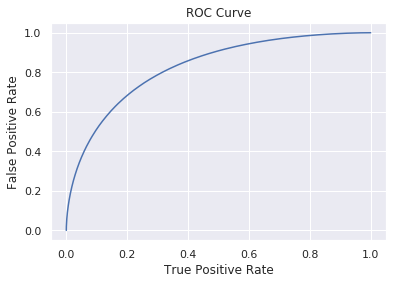

Training set areaUnderROC: 0.8253838455897303


In [101]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#### Test Data (Baseline)
Now we test this model against test data and achieved roughly 69.9% accuracy with our models.

In [106]:
predictions_lr = lrModel.transform(_featurized_test_df_base_local)
predictions_lr.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[0.12876466541696...|       0.0|[0.53214676160629...|
|    0|[-0.3467750551548...|       1.0|[0.41416467964242...|
|    0|[2.39899682036913...|       0.0|[0.91675077404969...|
|    0|[2.05835579687620...|       0.0|[0.88678920656643...|
|    0|[2.08598715595327...|       0.0|[0.88953372556611...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [98]:
def score(data):
    '''
    Function used to pull accuracy of measure for our predictions
    
    Args:
            data(DataFrame): Dataframe carrying the true labels and predictions

    Return:
            accuracy(float): Returns the accuracy of our model
    
    '''
    #Filter out the incorrect predictions and devide by the total count of rows
    accuracy = data.filter(data.label == data.prediction).count()/float(data.count())
    
    return(accuracy)

#### Accuracy:

In [107]:
print('Accuracy score for Logistic Regression', score(predictions_lr))

Accuracy score for Logistic Regression 0.6992418629799527


### Check Performance on Test Data (with feature engineering)
Next, we wanted to see if the inclusion of our engineered features improved our model accuracies so we trained another model with 40 iterations on the training data with engineered features.

In [82]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)
lrModel = lr.fit(_featurized_train_df)
print(f"\n... trained Logistic Regression in {time.time() - start} seconds")


... trained Logistic Regression in 192.23243117332458 seconds


The area under ROC for our model trained on the dataset with engineered features actually became worse with our feature engineering efforts when we trained with more epochs. We may be overfitting at this point.

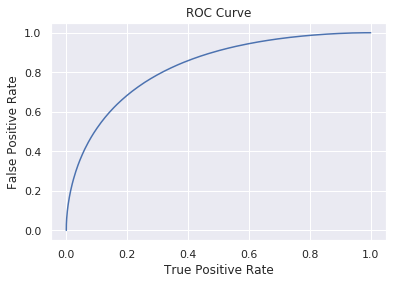

Training set areaUnderROC: 0.8264375886670251


In [91]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#### Test Data (Engineered Features)

We now test our model using the test dataset. With feature engineering we saw a nominal increase in accuracy. Accuracy went from 69.92% (Baseline), to 70.00% (engineered features). Unfortunately, not knowing what the features represent makes feature engineering particularly difficult, especially on such large datasets.

In [94]:
predictions_lr = lrModel.transform(_featurized_test_df_local)
predictions_lr.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[0.88921256470321...|       0.0|[0.70872764683809...|
|    0|[1.36340169906146...|       0.0|[0.79631200673933...|
|    1|[1.71947844800527...|       0.0|[0.84806164495546...|
|    0|[-1.0802761714451...|       1.0|[0.25345375733812...|
|    1|[-0.5725445491716...|       1.0|[0.36064989096624...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



#### Accuracy:

In [95]:
print('Accuracy score for Logistic Regression', score(predictions_lr))

Accuracy score for Logistic Regression 0.6999640255610097


### Check Performance on 1000 Iterations

Next, we wanted to test whether or not increasing the number of trained iterations improved our model performance. 

In [108]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=1000)
lrModel = lr.fit(_featurized_train_df)
print(f"\n... trained Logistic Regression in {time.time() - start} seconds")


... trained Logistic Regression in 1355.8183526992798 seconds


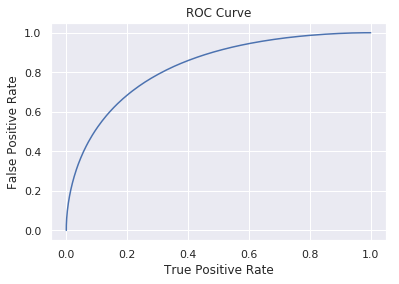

Training set areaUnderROC: 0.8268178800978709


In [111]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#### Test Data Prediction After 1000 Iterations

As seen, below, the accuracy went down slightly. Improvement from the model trained on 40 epochs is nominal. Stronger regularization may improve the accuracy of our models, but it is difficult to tell.

In [109]:
predictions_lr = lrModel.transform(_featurized_test_df_local)
#predictions_lr.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

In [110]:
print('Accuracy score for Logistic Regression', score(predictions_lr))

Accuracy score for Logistic Regression 0.6998324740622166


### Discussion

To summarize, the highest accuracy we were able to achieve was roughly 70% using the dataset that included engineered features. Though this accuracy is a nominal improvement relative to baseline, it is important to note that our models predicted true negatives better when trained on the dataset with engineered features. Unfortunately for our purpose, it would actually be better if we improved our true positive prediction rate (instead of true negative) as this would lead to a better CTR prediction rate, and translate to a higher payout rate from the advertisers. In reality, it is likely that more ads are not clicked (0) than they are clicked (1).

Another important piece of data is that the calculated area under ROC is highly sensitive to the data partition. This was identified after we ran our full models and observed a disparity between our model area under ROC, versus the area under ROC from our training and dev mini sets. In our initial data exploration and feature engineering efforts we found that many of these feature engineering efforts lead to fairly substantial improvements to area under ROC. With the number of unique categories present, it is likely that some very specific unique features are highly predictive for the class, clicked. Prior to beginning feature engineering, we were particularly cognizant of this risk, which is why we ran many summary statistics on our mini feature engineering dataset to compare against our full train set. Although we thought we were on the right path, with such a high dimensional and completely anonymized dataset, any attempt to understand the features is a real shot in the dark. This exercise truly highlights the importance of understanding the data, it's features, and it's limitations.


## 5. Application of Course Concepts

In the course of our analysis, we used a number of key course concepts gained from w261: Machine Learning at Scale. They include but are not limited to Lazy Evaluation, One Hot Encoding/FeatureHasher, Gradient Descent, and Regularization.

### One Hot Encoding/Feature Hasher

One hot encoding is a representation of categorical variables as binary features. Most machine learning algorithms are unable to work with non-numerical values and hence they need to be converted a series of dummy variables that is machine learning algorithm-friendly.

This usually happens in the below 2 steps:
1. Map unique categorical values and give them their own columns in a matrix
2. Convert each row of data where a value of 1 in a column of the new matrix maps back to the feature(s) being binarized.

This means that this new matrix can be very sparse when we have a high dimensional dataset with many unique categorical features. This becomes particularly problematic in the context of machine learning at scale because this means that we would need a lot of memory to run any computations on the data.

In the dataset we are given to work with, we identified that the first 14 columns were numerical and the remaining 25 were categorical variables. An important design decision that we made was to represent all features (integer and categorical) as categorical features. This makes the one hot encoded representation of this dataset highly sparse and intractable. To address this issue, we leveraged FeatureHasher, which takes what would have been a sparse matrix, and translates it into a dense representation. This lends itself well to logistic regression because it means that we only need to broadcast a weight matrix, and pull the weights for relevant indices that represnt the dummy variable of interest. Updating weights simply becomes a reduce step, aggregating weights across indices for each training example. FeatureHasher's dense representation of data offers a unique trait known as "online learning" in which the model does not need a lot of memory to run it's computations. The model can immediately learn online and update the hyperparameters as it needs. 

With FeatureHasher comes a new parameter that we needed to tune, which is the number of features to hash to. This is a particularly important parameter to tune because this directly affects the number of "collisions" we may have in the dataset. As mentioned previously, feature hasher represents each unique feature as a number. It then takes the modulo (remainder) of the number of features we would like to hash to in order to derive the index that will represent the unique feature. Although, in most cases, feature hashing is tolerant of some level of collisions, a high number of collisions can add a great deal of noise to our models. In some cases, collisions can actually be somewhat favorable, especially when working with many unique categorical features because it adds some level of regularization to the model. After experimenting with both feature engineering and the number of features to hash to, we determined that 2^20 hash bits would be optimal. 

### Lazy Evaluation

Lazy evaluation is an evaluation strategy in programming that delays the evaluation of an expression until its value is needed. This is effective in preventing repeated computation of the same expression. Spark employs this strategy in its evaluation of data stored in the form of RDDs and does not initiate the execution of transformations until an action is triggered. It is quite possible that one has executed several cells in their Jupyter Notebook but the data may have remained as is if the cells executed have not reached any action.

We needed to be mindful of this concept throughout the course of this project as we used Spark heavily for data exploration, model building, and model testing. It was perhaps even more prevalent during the earlier phases of the project when we were conducting EDA and feature engineering, and applying various transformations to the dataset when dissecting and preparing the data for subsequent machine learning algorithmic analysis. As the dataset we were working with was relatively large, each transformation takes a long time and we would often try out the transformation on a smaller sample to see how well our machines can handle the workload. Failing to recognize the lazy evaluating nature of of Spark can cause us to incorrectly assess the time and computational resources required in completing the work at scale.

### RDDs , DataFrames, and Scalability

Throughout the course of this project, our team used both RDDs and DataFrames to efficiently parse through the data and test our models. DataFrames became particularly useful when conducting exploratory data analysis and feature engineering. We leveraged Spark's DataFrame API to define the schema of our dataset, allowing us to control how we wanted to represent the data we were working with. Unlike RDD's, DataFrames organize data into columns, which lends itself to being highly efficient for different types of calculations. Spark's built in functions for data summarization and manipulation made using DataFrames highly efficient when generating key summary stats for each of our variables in our initial EDA.

When developing our logistic regression model from scratch, we leveraged RDDs to efficiently parse through the data row by row. With this came a series of challenges that we needed to work through. In our initial modeling efforts, we attempted to use the one-hot encoded version of the data to run our computations, but this proved to be inefficient and too memory intensive for our systems. When leveraging FeatureHasher's outputs, we were able to overcome our memory constraints by leveraging the indices generated in the dense representation to pull in the relevant weights from the broadcasted weight vector. This allowed us to calculate our predictions without ever expanding each row into its full one-hot encoded sparse matrix utilizing RDDs and all of the wonderful functions and efficiencies they have to offer.

Another important feature is Spark's ability to cache interim RDDs and DataFrames that may be used for other downstream tasks. The ability to cache an RDD or DataFrame means that we do not need to repeat the calculation multiple times. This does not come without its shortcomings. Caching many interim results can lead to performance degradation as available memory diminishes. Carefully choosing what to cache has improved the performance of our model computation time, and has made feature engineering and model optimization particularly efficient. As mentioned earlier, we leveraged FeatureHasher to represent our data as dense indices. Caching DataFrames, has allowed us to efficiently generate new hashed features and test different combinations of various features quickly without having to repeat previous calculations. This has allowed us to focus more of our time on optimizing different features.

In our initial model development efforts, we tried to implement logistic regression using DataFrames from scratch. One the most important learnings from this exercise was to AVOID UDFs AT ALL COST. As mentioned in lecture, the use of UDFs causes us to lose all of the beautiful optimizations that can be had from the catalyst optimizer and column level transformations. Despite working beautifully on the 5 row toy dataset, implementing UDFs caused our kernel to crash when using the full train dataset so we decided to implement the RDD version instead. As evidence from ML's Logistic Regression package, it is not only possible to implement logistic regression in DataFrames, but it is also far more computationally efficient. Our future goal will be to pursue this side project further.


### Gradient Descent

Gradient descent is an optimization algorithm, based on a convex function, that tweaks it's parameters iteratively to minimize a given function to its local minima. A practical application would be to leverage the first and second order conditions for convexity by traveling down the direction of steepest descent to identify where a local minimum for a function resides. This method allows us to minimize the loss function so that we achieve an optimal solution, without ever looking at the total error space.

Visually this process would look like the image below. Picture a blindfolded hamster present at location `x0`. It needs to get to the bottom of the valley to meet up with its children asap. It feels out the steepest path with it's feet and decides that `x1` is the steepest and takes the step. It does this repeatedly until it gets to `x4` and is eventually reunited with its children!

<img src="./images/gd.png">

In our model development, building, and testing we have implemented logistic regression with either batch gradient descent or mini-batch gradient descent. The primary difference between batch and mini-batch is mini-batch allows us to process the data in chunks instead of all at once like batch. After the model goes through a chunk (or mini-batch) of the data, it will update the weights and go through the next chunk of data. By doing this, we iteratively update the weights in waves as we pass through the data. For logistic regression, our models use logloss as the cost function (as described in the algorithm explanation section). The partial derivative of this cost function lends itself nicely for conducting distributed calculations.

### Regularization
Overfitting is a common machine learning problem. In this situation, a trained model performs poorly on out of sample tests, as it has "memorized" or overfitted to the training data rather than learning generalizable patterns. For neural models, "dropout" is often used to avoid overfitting. This is a similar concept to that of excluding certain features randomly within a particular random forest tree. In logistic regression, this option is not available, so instead, we turn to "regularization". Regularization involves adding a penalty term to the loss function which increases as parameter weights increase. This forces the model to avoid large parameter values unless the added predictive value is large. Depending on the form of regularization (ridge or lasso), the model will drive unimportant features towards zero. This helps prevent overfitting and, in theory, allows our models to generalize better to unseen examples. We use regularization in our logistic regression model for this purpose.

L1 (lasso) regularization performs feature selection. It does this by assigning insignificant input features to have zero weights effectively driving the impact they have down to zero. The equation L1 norm looks like:

<img src="./images/l1.png">

L2 (ridge) regularization forces the feature weights to be small but does not drive them to zero. It performs better when all the input features have influence over the output and have similar weights. The L2 norm looks like:

<img src="./images/l2.png">

In order to adhere to Pyspark'a parallelization architecture, we implemented regularization calculation as an optional parameter directly into the gradient calculation so as to prevent any excessive computations. 

## References

Criteo S.A. 10-K (2018). https://www.bamsec.com/filing/157642719000014?cik=1576427

Donges, N. (2018). The Logistic Regression Algorithm. https://machinelearning-blog.com/2018/04/23/logistic-regression-101/

Hamilton, K. (2019). Material has been adapted from Assignment-4 and lecture material

“Beat the Benchmark with Less Then 200MB of Memory.” Kaggle, www.kaggle.com/c/criteo-display-ad-challenge/discussion/10322#latest-291615. 

“Beginner's Guide to Click-Through Rate Prediction with Logistic Regression | Turi Notebook.” Turi, turi.com/learn/gallery/notebooks/click_through_rate_prediction_intro.html. 

“Feature Hashing.” Wikipedia, Wikimedia Foundation, 14 Dec. 2018, en.wikipedia.org/wiki/Feature_hashing. Gupta, Ankit, et al. 

“Complete Guide on DataFrame Operations in PySpark.” Analytics Vidhya, 11 Mar. 2019, www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/. 

“Logistic Regression.” Wikipedia, Wikimedia Foundation, 15 Apr. 2019, en.wikipedia.org/wiki/Logistic_regression. Pellarolo, Martín, and Martín Pellarolo. 

“Logistic Regression from Scratch in Python.” Medium, Medium, 23 Feb. 2018, medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac. 

“Sklearn.feature_extraction.FeatureHasher¶.” Scikit, scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.FeatureHasher.html.

"Gradient Descent in a Nutshell." Towards Data Science, 07 Mar. 2018, https://towardsdatascience.com/gradient-descent-in-a-nutshell-eaf8c18212f0 

"L1 and L2 Regularization." Medium, 04 Nov. 2018, https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2

"Regularization for Logistic Regression: L1, L2, Gauss or Laplace?" KNIME, 12 Mar. 2018, https://www.knime.com/blog/regularization-for-logistic-regression-l1-l2-gauss-or-laplace

